In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from glob import glob
import os
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

**GESTIONE DEI DATASET RELATIVI AL TRAFFICO**

Gestione del dataset V_OPD_ADT_APP_DIRMAR.csv.

Contiene l'anagrafica delle direzioni di marcia degli apparati.
* APP_ID = Numero identificativo della postazione MTS.
* APP_TIPO_SENSORE_DES = Descrizione del tipo di sensore installato nella postazione.
* DIRMAR_COD = Direzione di marcia, può assumere il valore 0 o 1
* DIRMAR_LOCALITA = Località in cui è situata la postazione.
* APP_TRATTO = Tratto stradale monitorato dalla postazione.
* APP_LATITUDINE = Coordinata geografica della postazione (latitudine).
* APP_LONGITUDINE = Coordinata geografica della postazione (longitudine).
* STR_ARS_NOM = Nome della strada su cui è installata la postazione.
* APP_PROG_K = Progressiva chilometrica della postazione lungo la strada.
* STR_NN_CARREGGIATE = Numero di carreggiate della strada monitorata.
* STR_NN_CORSIE = Numero di corsie della strada monitorata.
* COM_ISTAT_COD = Codice ISTAT del comune in cui si trova la postazione.
* COM_DESCR = Nome del comune in cui si trova la postazione.
* PROV_COD = Codice della provincia di appartenenza della postazione.


Selezione delle features utili: APP_ID, DIRMAR_COD, DIRMAR_LOCALITA e PROV_COD.

APP_ID e DIRMAR_COD per effettuare il merge con i dataset contenenti i flussi di traffico.

PROV_COD per il filtraggio per la provincia di Bologna.

Output: df_DIRMAR_filtrato

Dataset contenente l'anagrafica delle direzioni di marcia per Bologna.

In [ ]:
file_path_DIR_MAR = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/V_OPD_ADT_APP_DIRMAR.csv"
df_DIRMAR = pd.read_csv(file_path_DIR_MAR)

#Selezione delle features rilevanti APP_ID, DIRMAR_COD, DIRMAR_LOCALITA e PROV_COD
#Filtraggio per la provincia di Bologna
df_DIRMAR_filtrato= df_DIRMAR[df_DIRMAR["PROV_COD"] == "BO"][["APP_ID", "DIRMAR_COD", "DIRMAR_LOCALITA", "PROV_COD"]]

df_DIRMAR_filtrato.head()

,APP_ID,DIRMAR_COD,DIRMAR_LOCALITA,PROV_COD
2,7,0,DA PORRETTA TERME A FERRARA,BO
3,7,1,DA FERRARA A PORRETTA TERME,BO
18,52,0,DA BOLOGNA A RAVENNA,BO
19,52,1,DA RAVENNA A BOLOGNA,BO
96,152,0,DA BAZZANO A CASALECCHIO DI RENO,BO


Gestione dei dataset relativi ai flussi di traffico.

I dataset sono suddivisi per mese e ogni dataset contiene i dati relativi ai flussi di traffico,  misurati al quarto d'ora.
* ANNO_ID = Anno di rilevazione nel formato “aaaa”.
* MESE_ID = Mese di rilevazione nel formato “aaaamm”.
* GIO_ID = Giorno di rilevazione nel formato “aaaammgg”.
* HHMI_ID = Ora di aggregazione al quarto d’ora nel formato “hh:mm”.
* APP_ID = Numero della postazione MTS.
* DIRMAR_COD = Direzione di marcia, può assumere il valore 0 o 1.
* VEI_ID = Tipologia di veicolo, può assumere il valore da 0 a 10, la descrizione della tipologia è presente nel file Classi di Veicolo.
* NUM_TRANSITI = Numero di transiti aggregati al quarto d’ora della tipologia di veicolo registrata.

Selezione delle features rilevanti: GIO_ID, APP_ID, DIRMAR_COD, NUM_TRANSITI.

Trasformazione delle misurazioni dal quarto d'ora all'ora, sommando il numero dei transiti per tutti i tipi di veicolo.

Output: df_traffico_annuale
* GIO_ID = Giorno di rilevazione nel formato “aaaammgg”.
* ORA = Ora della rilevazione
* APP_ID = Numero della postazione MTS.
* DIR_MAR_COD = Direzione di marcia, può assumere il valore 0 o 1.
* NUM_TRANSITI = Numero di transiti orari

Dataset annuale con i conteggi del numero di transiti all'ora per la regione dell'Emilia Romagna, suddivisi per stazione e direzione di marcia.

In [ ]:
#Cartella contenente tutti i file mensili di traffico
cartella_dati_flussi_traffico_2024 = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/Flussi di Traffico 2024/"

#Trova tutti i file CSV nella cartella
file_csv_traffico = sorted(glob(cartella_dati_flussi_traffico_2024 + "*.csv"))

#Lista per accumulare i dataframe
dati_annuali = []

#Ciclo su tutti i file trovati
for file in file_csv_traffico:
    df_traffico_completo = pd.read_csv(file)

    #Selezione delle colonne rilevanti
    df_traffico_completo = df_traffico_completo[["GIO_ID", "HHMI_ID", "APP_ID", "DIRMAR_COD", "NUM_TRANSITI"]]

    #Estrazione dell'ora da HHMI_ID (che è in formato hh:mm)
    df_traffico_completo["ORA"] = df_traffico_completo["HHMI_ID"].str[:2]

    #Aggregazione dei dati su base oraria
    df_Traffico_orario = df_traffico_completo.groupby(["GIO_ID", "ORA", "APP_ID", "DIRMAR_COD"], as_index=False).agg({"NUM_TRANSITI": "sum"})

    #Aggiunta del dataset alla lista
    dati_annuali.append(df_Traffico_orario)

#Unione di tutti i dataset mensili in un unico dataset annuale
df_traffico_annuale_2024 = pd.concat(dati_annuali, ignore_index=True)

#Dataset risultante
df_traffico_annuale_2024.head()


,GIO_ID,ORA,APP_ID,DIRMAR_COD,NUM_TRANSITI
0,20240101,00,6,0,62
1,20240101,00,6,1,54
2,20240101,00,9,0,13
3,20240101,00,9,1,6
4,20240101,00,12,0,167


In [ ]:
#Cartella contenente tutti i file mensili di traffico
cartella_dati_flussi_traffico_2023 = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/Flussi di Traffico 2023/"

#Trova tutti i file CSV nella cartella
file_csv_traffico = sorted(glob(cartella_dati_flussi_traffico_2023 + "*.csv"))

#Lista per accumulare i dataframe
dati_annuali = []

#Ciclo su tutti i file trovati
for file in file_csv_traffico:
    df_traffico_completo = pd.read_csv(file)

    #Selezione delle colonne rilevanti
    df_traffico_completo = df_traffico_completo[["GIO_ID", "HHMI_ID", "APP_ID", "DIRMAR_COD", "NUM_TRANSITI"]]

    #Estrazione dell'ora da HHMI_ID (che è in formato hh:mm)
    df_traffico_completo["ORA"] = df_traffico_completo["HHMI_ID"].str[:2]

    #Aggregazione dei dati su base oraria
    df_Traffico_orario = df_traffico_completo.groupby(["GIO_ID", "ORA", "APP_ID", "DIRMAR_COD"], as_index=False).agg({"NUM_TRANSITI": "sum"})

    #Aggiunta del dataset alla lista
    dati_annuali.append(df_Traffico_orario)

#Unione di tutti i dataset mensili in un unico dataset annuale
df_traffico_annuale_2023 = pd.concat(dati_annuali, ignore_index=True)

#Dataset risultante
df_traffico_annuale_2023.head()


,GIO_ID,ORA,APP_ID,DIRMAR_COD,NUM_TRANSITI
0,20230101,00,6,0,53
1,20230101,00,6,1,96
2,20230101,00,7,0,35
3,20230101,00,7,1,37
4,20230101,00,9,0,20


In [ ]:
#Cartella contenente tutti i file mensili di traffico
cartella_dati_flussi_traffico_2022 = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/Flussi di Traffico 2022/"

#Trova tutti i file CSV nella cartella
file_csv_traffico = sorted(glob(cartella_dati_flussi_traffico_2022 + "*.csv"))

#Lista per accumulare i dataframe
dati_annuali = []

#Ciclo su tutti i file trovati
for file in file_csv_traffico:
    df_traffico_completo = pd.read_csv(file)

    #Selezione delle colonne rilevanti
    df_traffico_completo = df_traffico_completo[["GIO_ID", "HHMI_ID", "APP_ID", "DIRMAR_COD", "NUM_TRANSITI"]]

    #Estrazione dell'ora da HHMI_ID (che è in formato hh:mm)
    df_traffico_completo["ORA"] = df_traffico_completo["HHMI_ID"].str[:2]

    #Aggregazione dei dati su base oraria
    df_Traffico_orario = df_traffico_completo.groupby(["GIO_ID", "ORA", "APP_ID", "DIRMAR_COD"], as_index=False).agg({"NUM_TRANSITI": "sum"})

    #Aggiunta del dataset alla lista
    dati_annuali.append(df_Traffico_orario)

#Unione di tutti i dataset mensili in un unico dataset annuale
df_traffico_annuale_2022 = pd.concat(dati_annuali, ignore_index=True)

#Dataset risultante
df_traffico_annuale_2022.head()


,GIO_ID,ORA,APP_ID,DIRMAR_COD,NUM_TRANSITI
0,20220101,00,6,0,76
1,20220101,00,6,1,74
2,20220101,00,7,0,30
3,20220101,00,7,1,32
4,20220101,00,12,0,66


In [ ]:
#Cartella contenente tutti i file mensili di traffico
cartella_dati_flussi_traffico_2021 = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/Flussi di Traffico 2021/"

#Trova tutti i file CSV nella cartella
file_csv_traffico = sorted(glob(cartella_dati_flussi_traffico_2021 + "*.csv"))

#Lista per accumulare i dataframe
dati_annuali = []

#Ciclo su tutti i file trovati
for file in file_csv_traffico:
    df_traffico_completo = pd.read_csv(file)

    #Selezione delle colonne rilevanti
    df_traffico_completo = df_traffico_completo[["GIO_ID", "HHMI_ID", "APP_ID", "DIRMAR_COD", "NUM_TRANSITI"]]

    #Estrazione dell'ora da HHMI_ID (che è in formato hh:mm)
    df_traffico_completo["ORA"] = df_traffico_completo["HHMI_ID"].str[:2]

    #Aggregazione dei dati su base oraria
    df_Traffico_orario = df_traffico_completo.groupby(["GIO_ID", "ORA", "APP_ID", "DIRMAR_COD"], as_index=False).agg({"NUM_TRANSITI": "sum"})

    #Aggiunta del dataset alla lista
    dati_annuali.append(df_Traffico_orario)

#Unione di tutti i dataset mensili in un unico dataset annuale
df_traffico_annuale_2021 = pd.concat(dati_annuali, ignore_index=True)

#Dataset risultante
df_traffico_annuale_2021.head()


,GIO_ID,ORA,APP_ID,DIRMAR_COD,NUM_TRANSITI
0,20210101,00,7,1,1
1,20210101,00,9,1,1
2,20210101,00,16,0,2
3,20210101,00,16,1,1
4,20210101,00,19,0,3


In [ ]:
#Cartella contenente tutti i file mensili di traffico
cartella_dati_flussi_traffico_2020 = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Traffico/Flussi di Traffico 2020/"

#Trova tutti i file CSV nella cartella
file_csv_traffico = sorted(glob(cartella_dati_flussi_traffico_2020 + "*.csv"))

#Lista per accumulare i dataframe
dati_annuali = []

#Ciclo su tutti i file trovati
for file in file_csv_traffico:
    df_traffico_completo = pd.read_csv(file)

    #Selezione delle colonne rilevanti
    df_traffico_completo = df_traffico_completo[["GIO_ID", "HHMI_ID", "APP_ID", "DIRMAR_COD", "NUM_TRANSITI"]]

    #Estrazione dell'ora da HHMI_ID (che è in formato hh:mm)
    df_traffico_completo["ORA"] = df_traffico_completo["HHMI_ID"].str[:2]

    #Aggregazione dei dati su base oraria
    df_Traffico_orario = df_traffico_completo.groupby(["GIO_ID", "ORA", "APP_ID", "DIRMAR_COD"], as_index=False).agg({"NUM_TRANSITI": "sum"})

    #Aggiunta del dataset alla lista
    dati_annuali.append(df_Traffico_orario)

#Unione di tutti i dataset mensili in un unico dataset annuale
df_traffico_annuale_2020 = pd.concat(dati_annuali, ignore_index=True)

#Dataset risultante
df_traffico_annuale_2020.head()


,GIO_ID,ORA,APP_ID,DIRMAR_COD,NUM_TRANSITI
0,20200101,00,6,0,69
1,20200101,00,6,1,90
2,20200101,00,7,0,52
3,20200101,00,7,1,45
4,20200101,00,9,0,19


Filtraggio del flusso del traffico per Bologna.

Merge tra il dataset df_DIRMAR_filtrato e df_traffico_annuale dal 2020 al 2024.

Output:df_traffico_staz

Dataset annuale dal 2020 al 2024 con i conteggi del numero di transiti all'ora relativi a Bologna, suddivisi per stazione e direzione di marcia.


In [ ]:
#Merge includendo l'ora
df_traffico_staz2024 = pd.merge(df_DIRMAR_filtrato, df_traffico_annuale_2024, on=["APP_ID", "DIRMAR_COD"], how="inner")
df_traffico_staz2023 = pd.merge(df_DIRMAR_filtrato, df_traffico_annuale_2023, on=["APP_ID", "DIRMAR_COD"], how="inner")
df_traffico_staz2022 = pd.merge(df_DIRMAR_filtrato, df_traffico_annuale_2022, on=["APP_ID", "DIRMAR_COD"], how="inner")
df_traffico_staz2021 = pd.merge(df_DIRMAR_filtrato, df_traffico_annuale_2021, on=["APP_ID", "DIRMAR_COD"], how="inner")
df_traffico_staz2020 = pd.merge(df_DIRMAR_filtrato, df_traffico_annuale_2020, on=["APP_ID", "DIRMAR_COD"], how="inner")

df_traffico_staz= pd.concat(
    [df_traffico_staz2024,df_traffico_staz2023,df_traffico_staz2022,df_traffico_staz2021,df_traffico_staz2020],
    ignore_index=True
)


#Riordinamento delle colonne mantenendo GIO_ID e ORA all'inizio
colonne_riordinate = ["GIO_ID", "ORA"] + [col for col in df_traffico_staz.columns if col not in ["GIO_ID", "ORA"]]
df_traffico_staz = df_traffico_staz[colonne_riordinate]

#Ordinamento per data, ora e postazione
df_traffico_staz = df_traffico_staz.sort_values(by=["GIO_ID", "ORA", "APP_ID"]).reset_index(drop=True)

#Dataset risultante
df_traffico_staz


,GIO_ID,ORA,APP_ID,DIRMAR_COD,DIRMAR_LOCALITA,PROV_COD,NUM_TRANSITI
0,20200101,00,7,0,DA PORRETTA TERME A FERRARA,BO,52
1,20200101,00,7,1,DA FERRARA A PORRETTA TERME,BO,45
2,20200101,00,52,0,DA BOLOGNA A RAVENNA,BO,39
3,20200101,00,52,1,DA RAVENNA A BOLOGNA,BO,48
4,20200101,00,152,0,DA BAZZANO A CASALECCHIO DI RENO,BO,340
...,...,...,...,...,...,...,...
2939907,20241231,23,627,1,DA FERRARA A PORRETTA TERME,BO,26
2939908,20241231,23,684,0,DA BOLOGNA A CASTEL MAGGIORE,BO,70
2939909,20241231,23,684,1,DA CASTEL MAGGIORE A BOLOGNA,BO,63
2939910,20241231,23,685,0,DA ZOLA PREDOSA A TOLE',BO,13


Somma di tutti i transiti orari.

Output: df_traffico
* GIO_ID = Giorno di rilevazione nel formato “aaaammgg”.
* ORA = ora della rilevazione
* NUM_TRANSITI = Numero di transiti orari

Dataset annuale dal 2020 al 2024 con i conteggi del numero di transiti all'ora relativi a Bologna.

Aggiunta della data 31/03/2024 ora 2 poiché a causa dell'ora legale non era stata effettuata la misurazione per l'ora 2 del 31 marzo 2024, viene utilizzato il numero di transiti dell'ora precedente (ora 1) per completare la misurazione.

In [ ]:
#Raggruppamento dei dati per giorno e ora
df_traffico = df_traffico_staz.groupby(["GIO_ID", "ORA"], as_index=False)[["NUM_TRANSITI"]].sum()

#Conversione GIO_ID in datetime e rimozione dell'orario
df_traffico['GIO_ID'] = pd.to_datetime(df_traffico['GIO_ID'], format='%Y%m%d').dt.date

#Valore di NUM_TRANSITI per l'ora 1 del 31 marzo
num_transiti_1 = df_traffico.loc[(df_traffico["GIO_ID"] == pd.to_datetime("2024-03-31").date()) &
                                 (df_traffico["ORA"] == "01"), "NUM_TRANSITI"]

#Se l'ora 1 non esiste, assegna un valore di default
num_transiti_2 = num_transiti_1.values[0] if not num_transiti_1.empty else 0

#Creazione della riga mancante per il 31 marzo alle ore 2
data_mancante = pd.DataFrame({
    "GIO_ID": [pd.to_datetime("2024-03-31").date()],
    "ORA": ["02"],
    "NUM_TRANSITI": [num_transiti_2]
})

#Aggiunta della riga e riordinamento
df_traffico = pd.concat([df_traffico, data_mancante], ignore_index=True)
df_traffico = df_traffico.sort_values(by=["GIO_ID", "ORA"]).reset_index(drop=True)

#Sistemazione della data e dell'ora per il merge finale
df_traffico['ORA'] = df_traffico['ORA'].astype(int)
df_traffico['GIO_ID'] = pd.to_datetime(df_traffico['GIO_ID']).dt.date

#Dataset risultante
df_traffico


,GIO_ID,ORA,NUM_TRANSITI
0,2020-01-01,0,5935
1,2020-01-01,1,12846
2,2020-01-01,2,11953
3,2020-01-01,3,7366
4,2020-01-01,4,3921
...,...,...,...
43839,2024-12-31,19,11584
43840,2024-12-31,20,8244
43841,2024-12-31,21,3355
43842,2024-12-31,22,2805


**GESTIONE DEI DATASET RELATIVI ALL'INQUINAMENTO**

Creazione del dataset relativo all'inquinamento.

Gestione di tutti i dataset relativi all'inquinamento, ogni dataset è suddiviso per stazione e per parametro, ad esempio il dataset "storico_2024_07000014_005.csv" contiene le rilevazioni della stazione 07000014 per il parametro 5.

Nella cartella "BO_Stazione_Parametro" sono presenti i dataset delle stazioni relative solo alla provincia di Bologna.

I parametri sono identificati nel dataset "parametri - Sheet1.csv"

Se più stazioni calcolano lo stesso parametro, si calcola la media delle misurazioni.

Output: df_inquinamento
* GIO_ID: Giorno di rilevazione nel formato “aaaa-mm-gg”.
* ORA: Ora della rilevazione
* C6H6 (Benzene): valore misurato in ug/m3
* CO (Monossido di carbonio): valore misurato in ug/m3
* NO (Monossido di azoto): valore misurato in ug/m3
* NO2 (Biossido di azoto): valore misurato in ug/m3
* NOX (Ossidi di azoto): valore misurato in ug/m3
* O3 (Ozono): valore misurato in ug/m3
* PM10: valore misurato in ug/m3
* PM2.5: valore misurato in ug/m3

In [ ]:
#Cartella che contiene tutti i file delle misurazioni
cartella_dati_inquinamento = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/CSV BO Stazione_Parametro_2024"

#File con la tabella parametri (ID_PARAM -> Nome PARAMETRO)
file_parametri = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/parametri - Sheet1.csv"

#Caricmento del dataset dei parametri
df_parametri = pd.read_csv(file_parametri)
df_parametri = df_parametri[["IdParametro", "PARAMETRO"]]  # Seleziona solo ID e nome

#Trova tutti i file CSV nella cartella
file_inquinamento = glob(os.path.join(cartella_dati_inquinamento, "*.csv"))

#Lista per accumulare i dataframe
df_list_inquinamento = []

#Lettura di tutti i file delle misurazioni
for file in file_inquinamento:
    df = pd.read_csv(file)

    #Convesrione delle date
    df['DATA_INIZIO'] = pd.to_datetime(df['DATA_INIZIO'], format='%d/%m/%Y %H')

    #Estrazione della data (senza ora)
    df['GIO_ID'] = df['DATA_INIZIO'].dt.date
    df['ORA'] = df['DATA_INIZIO'].dt.hour  # Estrai l'ora per i dati orari

    #Estrazione delle features utili
    df = df[['GIO_ID', 'ORA', 'ID_PARAM', 'VALORE']]

    #Unione con il dataset dei parametri per ottenere il nome del parametro
    df = df.merge(df_parametri, left_on="ID_PARAM", right_on="IdParametro", how="left")

    #Estrazione delle features utili:Data, Ora, Parametro e Valore
    df = df[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']]

    #Verifica se la misura è per tutta la giornata (ora = 0 per tutte le righe del giorno)
    df_giornaliero = df[df['ORA'] == 0].copy()

    if not df_giornaliero.empty:
        #Per i dati giornalieri, replicare per tutte le ore
        for ora in range(24):
            df_giornaliero['ORA'] = ora
            df_list_inquinamento.append(df_giornaliero[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

    #Aggiunta dei dati orari
    df_orari = df[df['ORA'] != 0]
    df_list_inquinamento.append(df_orari[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

#Unione di tutti i dati
df_totale = pd.concat(df_list_inquinamento, ignore_index=True)

#Aggregazione: se più stazioni misurano lo stesso parametro nello stesso giorno e ora -> Media
df_totale = df_totale.groupby(["GIO_ID", "ORA", "PARAMETRO"])["VALORE"].mean().reset_index()

#Pivot per avere il formato finale (colonne = parametri, righe = date e ore)
df_inquinamento2024= df_totale.pivot(index=["GIO_ID", "ORA"], columns="PARAMETRO", values="VALORE").reset_index()

#Arrotondamento alle prime due cifre decimali
df_inquinamento2024 = df_inquinamento2024.round(2)

#Sistemo il tipo data e ora per il merge finale
df_inquinamento2024['ORA'] = df_inquinamento2024['ORA'].astype(int)
df_inquinamento2024['GIO_ID'] = pd.to_datetime(df_inquinamento2024['GIO_ID']).dt.date

#Dataset risultante
df_inquinamento2024.head()


PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2024-01-01,0,1.80,0.60,25.0,22.00,67.0,15.00,21.67,19.5
1,2024-01-01,1,1.75,0.60,19.5,22.00,57.0,10.75,21.67,19.5
2,2024-01-01,2,1.50,0.55,17.5,19.83,51.5,18.50,21.67,19.5
3,2024-01-01,3,1.80,0.50,16.5,19.50,50.5,20.75,21.67,19.5
4,2024-01-01,4,1.40,0.50,17.5,19.33,51.5,21.00,21.67,19.5


In [ ]:
#Cartella che contiene tutti i file delle misurazioni
cartella_dati_inquinamento = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/CSV BO Stazione_Parametro_2023"

#File con la tabella parametri (ID_PARAM -> Nome PARAMETRO)
file_parametri = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/parametri - Sheet1.csv"

#Caricmento del dataset dei parametri
df_parametri = pd.read_csv(file_parametri)
df_parametri = df_parametri[["IdParametro", "PARAMETRO"]]  # Seleziona solo ID e nome

#Trova tutti i file CSV nella cartella
file_inquinamento = glob(os.path.join(cartella_dati_inquinamento, "*.csv"))

#Lista per accumulare i dataframe
df_list_inquinamento = []

#Lettura di tutti i file delle misurazioni
for file in file_inquinamento:
    df = pd.read_csv(file)

    #Convesrione delle date
    df['DATA_INIZIO'] = pd.to_datetime(df['DATA_INIZIO'], format='%d/%m/%Y %H')

    #Estrazione della data (senza ora)
    df['GIO_ID'] = df['DATA_INIZIO'].dt.date
    df['ORA'] = df['DATA_INIZIO'].dt.hour  # Estrai l'ora per i dati orari

    #Estrazione delle features utili
    df = df[['GIO_ID', 'ORA', 'ID_PARAM', 'VALORE']]

    #Unione con il dataset dei parametri per ottenere il nome del parametro
    df = df.merge(df_parametri, left_on="ID_PARAM", right_on="IdParametro", how="left")

    #Estrazione delle features utili:Data, Ora, Parametro e Valore
    df = df[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']]

    #Verifica se la misura è per tutta la giornata (ora = 0 per tutte le righe del giorno)
    df_giornaliero = df[df['ORA'] == 0].copy()

    if not df_giornaliero.empty:
        #Per i dati giornalieri, replicare per tutte le ore
        for ora in range(24):
            df_giornaliero['ORA'] = ora
            df_list_inquinamento.append(df_giornaliero[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

    #Aggiunta dei dati orari
    df_orari = df[df['ORA'] != 0]
    df_list_inquinamento.append(df_orari[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

#Unione di tutti i dati
df_totale = pd.concat(df_list_inquinamento, ignore_index=True)

#Aggregazione: se più stazioni misurano lo stesso parametro nello stesso giorno e ora -> Media
df_totale = df_totale.groupby(["GIO_ID", "ORA", "PARAMETRO"])["VALORE"].mean().reset_index()

#Pivot per avere il formato finale (colonne = parametri, righe = date e ore)
df_inquinamento2023= df_totale.pivot(index=["GIO_ID", "ORA"], columns="PARAMETRO", values="VALORE").reset_index()

#Arrotondamento alle prime due cifre decimali
df_inquinamento2023 = df_inquinamento2023.round(2)

#Sistemo il tipo data e ora per il merge finale
df_inquinamento2023['ORA'] = df_inquinamento2023['ORA'].astype(int)
df_inquinamento2023['GIO_ID'] = pd.to_datetime(df_inquinamento2023['GIO_ID']).dt.date

#Dataset risultante
df_inquinamento2023

PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2023-01-01,0,1.80,0.90,20.0,24.00,69.0,1.00,46.67,37.0
1,2023-01-01,1,1.75,0.90,25.0,23.00,76.5,1.00,46.67,37.0
2,2023-01-01,2,1.85,0.90,21.0,23.33,72.0,1.00,46.67,37.0
3,2023-01-01,3,1.70,0.90,18.0,22.67,65.5,1.00,46.67,37.0
4,2023-01-01,4,1.70,0.85,18.0,23.17,64.5,1.00,46.67,37.0
...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31,19,1.40,0.55,27.5,28.00,78.0,14.00,49.67,43.5
8756,2023-12-31,20,1.40,0.55,23.5,26.33,67.0,15.75,49.67,43.5
8757,2023-12-31,21,1.70,0.65,26.0,29.33,71.0,2.50,49.67,43.5
8758,2023-12-31,22,1.75,0.70,30.5,28.50,79.0,3.00,49.67,43.5


In [ ]:
#Cartella che contiene tutti i file delle misurazioni
cartella_dati_inquinamento = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/CSV BO Stazione_Parametro_2022"

#File con la tabella parametri (ID_PARAM -> Nome PARAMETRO)
file_parametri = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/parametri - Sheet1.csv"

#Caricmento del dataset dei parametri
df_parametri = pd.read_csv(file_parametri)
df_parametri = df_parametri[["IdParametro", "PARAMETRO"]]  # Seleziona solo ID e nome

#Trova tutti i file CSV nella cartella
file_inquinamento = glob(os.path.join(cartella_dati_inquinamento, "*.csv"))

#Lista per accumulare i dataframe
df_list_inquinamento = []

#Lettura di tutti i file delle misurazioni
for file in file_inquinamento:
    df = pd.read_csv(file)

    #Convesrione delle date
    df['DATA_INIZIO'] = pd.to_datetime(df['DATA_INIZIO'], format='%d/%m/%Y %H')

    #Estrazione della data (senza ora)
    df['GIO_ID'] = df['DATA_INIZIO'].dt.date
    df['ORA'] = df['DATA_INIZIO'].dt.hour  # Estrai l'ora per i dati orari

    #Estrazione delle features utili
    df = df[['GIO_ID', 'ORA', 'ID_PARAM', 'VALORE']]

    #Unione con il dataset dei parametri per ottenere il nome del parametro
    df = df.merge(df_parametri, left_on="ID_PARAM", right_on="IdParametro", how="left")

    #Estrazione delle features utili:Data, Ora, Parametro e Valore
    df = df[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']]

    #Verifica se la misura è per tutta la giornata (ora = 0 per tutte le righe del giorno)
    df_giornaliero = df[df['ORA'] == 0].copy()

    if not df_giornaliero.empty:
        #Per i dati giornalieri, replicare per tutte le ore
        for ora in range(24):
            df_giornaliero['ORA'] = ora
            df_list_inquinamento.append(df_giornaliero[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

    #Aggiunta dei dati orari
    df_orari = df[df['ORA'] != 0]
    df_list_inquinamento.append(df_orari[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

#Unione di tutti i dati
df_totale = pd.concat(df_list_inquinamento, ignore_index=True)

#Aggregazione: se più stazioni misurano lo stesso parametro nello stesso giorno e ora -> Media
df_totale = df_totale.groupby(["GIO_ID", "ORA", "PARAMETRO"])["VALORE"].mean().reset_index()

#Pivot per avere il formato finale (colonne = parametri, righe = date e ore)
df_inquinamento2022= df_totale.pivot(index=["GIO_ID", "ORA"], columns="PARAMETRO", values="VALORE").reset_index()

#Arrotondamento alle prime due cifre decimali
df_inquinamento2022 = df_inquinamento2022.round(2)

#Sistemo il tipo data e ora per il merge finale
df_inquinamento2022['ORA'] = df_inquinamento2022['ORA'].astype(int)
df_inquinamento2022['GIO_ID'] = pd.to_datetime(df_inquinamento2022['GIO_ID']).dt.date

#Dataset risultante
df_inquinamento2022

PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2022-01-01,0,2.90,1.20,85.0,24.00,168.0,1.00,51.67,47.0
1,2022-01-01,1,2.95,1.20,92.0,23.50,178.5,1.00,51.67,47.0
2,2022-01-01,2,3.30,1.35,101.5,25.50,195.0,1.00,51.67,47.0
3,2022-01-01,3,2.90,1.30,96.5,24.33,187.5,1.00,51.67,47.0
4,2022-01-01,4,3.10,1.20,98.0,24.00,189.0,1.00,51.67,47.0
...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,2.00,1.05,42.0,34.67,114.0,0.50,36.67,27.5
8756,2022-12-31,20,2.10,1.05,38.5,33.00,106.0,0.75,36.67,27.5
8757,2022-12-31,21,1.80,0.95,32.5,31.00,95.0,0.75,36.67,27.5
8758,2022-12-31,22,1.70,0.90,26.5,30.00,84.0,0.75,36.67,27.5


In [ ]:
#Cartella che contiene tutti i file delle misurazioni
cartella_dati_inquinamento = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/CSV BO Stazione_Parametro_2021"

#File con la tabella parametri (ID_PARAM -> Nome PARAMETRO)
file_parametri = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/parametri - Sheet1.csv"

#Caricmento del dataset dei parametri
df_parametri = pd.read_csv(file_parametri)
df_parametri = df_parametri[["IdParametro", "PARAMETRO"]]  # Seleziona solo ID e nome

#Trova tutti i file CSV nella cartella
file_inquinamento = glob(os.path.join(cartella_dati_inquinamento, "*.csv"))

#Lista per accumulare i dataframe
df_list_inquinamento = []

#Lettura di tutti i file delle misurazioni
for file in file_inquinamento:
    df = pd.read_csv(file)

    #Convesrione delle date
    df['DATA_INIZIO'] = pd.to_datetime(df['DATA_INIZIO'], format='%d/%m/%Y %H')

    #Estrazione della data (senza ora)
    df['GIO_ID'] = df['DATA_INIZIO'].dt.date
    df['ORA'] = df['DATA_INIZIO'].dt.hour  # Estrai l'ora per i dati orari

    #Estrazione delle features utili
    df = df[['GIO_ID', 'ORA', 'ID_PARAM', 'VALORE']]

    #Unione con il dataset dei parametri per ottenere il nome del parametro
    df = df.merge(df_parametri, left_on="ID_PARAM", right_on="IdParametro", how="left")

    #Estrazione delle features utili:Data, Ora, Parametro e Valore
    df = df[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']]

    #Verifica se la misura è per tutta la giornata (ora = 0 per tutte le righe del giorno)
    df_giornaliero = df[df['ORA'] == 0].copy()

    if not df_giornaliero.empty:
        #Per i dati giornalieri, replicare per tutte le ore
        for ora in range(24):
            df_giornaliero['ORA'] = ora
            df_list_inquinamento.append(df_giornaliero[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

    #Aggiunta dei dati orari
    df_orari = df[df['ORA'] != 0]
    df_list_inquinamento.append(df_orari[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

#Unione di tutti i dati
df_totale = pd.concat(df_list_inquinamento, ignore_index=True)

#Aggregazione: se più stazioni misurano lo stesso parametro nello stesso giorno e ora -> Media
df_totale = df_totale.groupby(["GIO_ID", "ORA", "PARAMETRO"])["VALORE"].mean().reset_index()

#Pivot per avere il formato finale (colonne = parametri, righe = date e ore)
df_inquinamento2021= df_totale.pivot(index=["GIO_ID", "ORA"], columns="PARAMETRO", values="VALORE").reset_index()

#Arrotondamento alle prime due cifre decimali
df_inquinamento2021 = df_inquinamento2021.round(2)

#Sistemo il tipo data e ora per il merge finale
df_inquinamento2021['ORA'] = df_inquinamento2021['ORA'].astype(int)
df_inquinamento2021['GIO_ID'] = pd.to_datetime(df_inquinamento2021['GIO_ID']).dt.date

#Dataset risultante
df_inquinamento2021

PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2021-01-01,0,0.60,0.80,3.0,14.33,28.0,28.50,48.67,43.0
1,2021-01-01,1,0.95,0.95,6.5,23.00,42.5,19.00,48.67,43.0
2,2021-01-01,2,0.60,0.95,5.0,26.67,48.0,15.75,48.67,43.0
3,2021-01-01,3,1.25,0.95,5.5,25.00,44.5,15.75,48.67,43.0
4,2021-01-01,4,1.25,1.00,7.5,23.83,45.5,15.75,48.67,43.0
...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,2.25,0.95,58.0,32.33,133.0,1.00,33.00,27.5
8756,2021-12-31,20,2.30,0.95,62.5,30.83,140.5,1.00,33.00,27.5
8757,2021-12-31,21,2.30,1.00,65.5,29.33,142.0,1.00,33.00,27.5
8758,2021-12-31,22,2.30,0.95,57.0,28.17,127.0,1.00,33.00,27.5


In [ ]:
#Cartella che contiene tutti i file delle misurazioni
cartella_dati_inquinamento = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/CSV BO Stazione_Parametro_2020"

#File con la tabella parametri (ID_PARAM -> Nome PARAMETRO)
file_parametri = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Inquinamento/parametri - Sheet1.csv"

#Caricmento del dataset dei parametri
df_parametri = pd.read_csv(file_parametri)
df_parametri = df_parametri[["IdParametro", "PARAMETRO"]]  # Seleziona solo ID e nome

#Trova tutti i file CSV nella cartella
file_inquinamento = glob(os.path.join(cartella_dati_inquinamento, "*.csv"))

#Lista per accumulare i dataframe
df_list_inquinamento = []

#Lettura di tutti i file delle misurazioni
for file in file_inquinamento:
    df = pd.read_csv(file)

    #Convesrione delle date
    df['DATA_INIZIO'] = pd.to_datetime(df['DATA_INIZIO'], format='%d/%m/%Y %H')

    #Estrazione della data (senza ora)
    df['GIO_ID'] = df['DATA_INIZIO'].dt.date
    df['ORA'] = df['DATA_INIZIO'].dt.hour  # Estrai l'ora per i dati orari

    #Estrazione delle features utili
    df = df[['GIO_ID', 'ORA', 'ID_PARAM', 'VALORE']]

    #Unione con il dataset dei parametri per ottenere il nome del parametro
    df = df.merge(df_parametri, left_on="ID_PARAM", right_on="IdParametro", how="left")

    #Estrazione delle features utili:Data, Ora, Parametro e Valore
    df = df[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']]

    #Verifica se la misura è per tutta la giornata (ora = 0 per tutte le righe del giorno)
    df_giornaliero = df[df['ORA'] == 0].copy()

    if not df_giornaliero.empty:
        #Per i dati giornalieri, replicare per tutte le ore
        for ora in range(24):
            df_giornaliero['ORA'] = ora
            df_list_inquinamento.append(df_giornaliero[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

    #Aggiunta dei dati orari
    df_orari = df[df['ORA'] != 0]
    df_list_inquinamento.append(df_orari[['GIO_ID', 'ORA', 'PARAMETRO', 'VALORE']])

#Unione di tutti i dati
df_totale = pd.concat(df_list_inquinamento, ignore_index=True)

#Aggregazione: se più stazioni misurano lo stesso parametro nello stesso giorno e ora -> Media
df_totale = df_totale.groupby(["GIO_ID", "ORA", "PARAMETRO"])["VALORE"].mean().reset_index()

#Pivot per avere il formato finale (colonne = parametri, righe = date e ore)
df_inquinamento2020= df_totale.pivot(index=["GIO_ID", "ORA"], columns="PARAMETRO", values="VALORE").reset_index()

#Arrotondamento alle prime due cifre decimali
df_inquinamento2020 = df_inquinamento2020.round(2)

#Sistemo il tipo data e ora per il merge finale
df_inquinamento2020['ORA'] = df_inquinamento2020['ORA'].astype(int)
df_inquinamento2020['GIO_ID'] = pd.to_datetime(df_inquinamento2020['GIO_ID']).dt.date

#Dataset risultante
df_inquinamento2020

PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2020-01-01,0,1.20,0.70,5.0,35.33,40.0,8.50,31.33,28.0
1,2020-01-01,1,1.20,0.70,5.0,35.67,46.0,11.00,31.33,28.0
2,2020-01-01,2,1.20,0.70,5.0,36.17,41.5,9.50,31.33,28.0
3,2020-01-01,3,1.20,0.75,7.0,35.17,45.0,9.50,31.33,28.0
4,2020-01-01,4,1.10,0.65,3.5,32.83,33.5,10.25,31.33,28.0
...,...,...,...,...,...,...,...,...,...,...
8779,2020-12-31,19,1.70,1.15,29.0,38.33,101.5,5.75,22.33,17.5
8780,2020-12-31,20,1.60,1.00,14.5,36.33,72.5,5.75,22.33,17.5
8781,2020-12-31,21,1.65,0.90,11.0,29.00,61.5,19.25,22.33,17.5
8782,2020-12-31,22,1.15,0.80,3.5,22.83,38.0,21.75,22.33,17.5


In [ ]:
lista_df = [df_inquinamento2024, df_inquinamento2023, df_inquinamento2022, df_inquinamento2021, df_inquinamento2020]
df_inquinamento = pd.concat(lista_df, ignore_index=True)


df_inquinamento.head()

PARAMETRO,GIO_ID,ORA,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5
0,2024-01-01,0,1.80,0.60,25.0,22.00,67.0,15.00,21.67,19.5
1,2024-01-01,1,1.75,0.60,19.5,22.00,57.0,10.75,21.67,19.5
2,2024-01-01,2,1.50,0.55,17.5,19.83,51.5,18.50,21.67,19.5
3,2024-01-01,3,1.80,0.50,16.5,19.50,50.5,20.75,21.67,19.5
4,2024-01-01,4,1.40,0.50,17.5,19.33,51.5,21.00,21.67,19.5


**GESTIONE DEI DATASET RELATIVI AL METEO**

I dataset sono suddivisi per mese e in forma giornaliera.

Ogni dataset contiene:
* LOCALITA: La località o città dove sono stati registrati i dati.
* DATA: La data di rilevazione dei dati, nel formato giorno/mese/anno.
* TMEDIA °C: La temperatura media giornaliera in gradi Celsius.
* TMIN °C: La temperatura minima giornaliera in gradi Celsius.
* TMAX °C: La temperatura massima giornaliera in gradi Celsius.
* PUNTORUGIADA °C: La temperatura del punto di rugiada.
* UMIDITA %: Il livello di umidità relativa nell'aria, espresso in percentuale.
* VISIBILITA km: La visibilità orizzontale in chilometri.
* VENTOMEDIA km/h: La velocità media del vento, misurata in chilometri all'ora.
* VENTOMAX km/h: La velocità massima del vento registrata durante la giornata.
* RAFFICA km/h: La velocità delle raffiche di vento, misurata in chilometri all'ora.
* PRESSIONESLM mb: La pressione atmosferica al livello del mare, misurata in millibar.
* PRESSIONEMEDIA mb: La pressione atmosferica media durante la giornata, misurata in millibar.
* PIOGGIA mm: La quantità di precipitazioni giornaliere, misurata in millimetri.
* FENOMENI: I fenomeni atmosferici osservati durante il giorno (ad esempio, nebbia, pioggia, temporale, ecc.).

Selezione delle features utili: DATA, TMEDIA °C e FENOMENI.
Poichè i dati sono misurati in giornata, è stata effettuata la trasformazione in ore, replicando i valori.

Output: df_meteo
* GIO_ID: Giorno di rilevazione nel formato “aaaa-mm-gg”.
* ORA: Ora della rilevazione
* TMEDIA °C: La temperatura media giornaliera in gradi Celsius.
* FENOMENI
* VENTOMEDIA km/h: La velocità media del vento, misurata in chilometri all'ora.
* UMIDITA %: Il livello di umidità relativa nell'aria, espresso in percentuale.

La colonna FENOMENI contiene i diversi fenomeni atmosferici:
* 0: Nessun fenomeno.
* 1: Pioggia.
* 2: Neve.
* 3: Nebbia.
* 4: Pioggia + Neve.
* 5: Pioggia + Nebbia.
* 6: Pioggia + Temporale.
* 7: Pioggia + Neve + Nebbia.
* 8: Pioggia + Neve + Temporale.

In [ ]:
#Cartella contenente tutti i file mensili
cartella_meteo = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Meteo/Meteo_BO_2024"

#Trova tutti i file CSV nella cartella
file_meteo = glob(os.path.join(cartella_meteo, "*.csv"))

#Lista per accumulare i dataframe
df_list = []

#Lettura e unione di tutti i file meteo
for file in file_meteo:
    df = pd.read_csv(file, delimiter=";")

    df.columns = df.columns.str.strip()  # Rimuove spazi extra

    #Conversione della data in formato datetime
    df['GIO_ID'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    #Estrazione delle features rilevanti
    df = df[['GIO_ID', 'TMEDIA °C', 'FENOMENI', 'UMIDITA %','VENTOMEDIA km/h' ]]

    #Replica dei valori giornalieri per ogni ora (0-23)
    df_expanded = pd.concat([df.assign(ORA=ora) for ora in range(24)])

    df_list.append(df_expanded)

#Unione
df_meteo2024 = pd.concat(df_list, ignore_index=True)

#Filtraggio dei dati per partire da gennaio 2024
df_meteo2024 = df_meteo2024[df_meteo2024['GIO_ID'] >= '2024-01-01']

#Ordinamento per 'GIO_ID' (data) e 'ORA' (ora)
df_meteo2024 = df_meteo2024.sort_values(by=['GIO_ID', 'ORA']).reset_index(drop=True)

#Funzione per codificare i fenomeni combinati
def codifica_fenomeni(fenomeni):
    fenomeni = str(fenomeni).lower()
    if 'pioggia' in fenomeni and 'neve' in fenomeni and 'nebbia' in fenomeni:
        return 7  # Pioggia + Neve + Nebbia
    elif 'pioggia' in fenomeni and 'neve' in fenomeni and 'temporale' in fenomeni:
        return 8  # Pioggia + Neve + Temporale
    elif 'pioggia' in fenomeni and 'neve' in fenomeni:
        return 4  # Pioggia + Neve
    elif 'pioggia' in fenomeni and 'nebbia' in fenomeni:
        return 5  # Pioggia + Nebbia
    elif 'pioggia' in fenomeni and 'temporale' in fenomeni:
        return 6  # Pioggia + Temporale
    elif 'pioggia' in fenomeni:
        return 1  # Pioggia
    elif 'neve' in fenomeni:
        return 2  # Neve
    elif 'nebbia' in fenomeni:
        return 3  # Nebbia
    else:
        return 0  # Nessun fenomeno

#Applicazione della funzione alla colonna "FENOMENI"
df_meteo2024['FENOMENI'] = df_meteo2024['FENOMENI'].apply(codifica_fenomeni)

#Riorganizzazione delle colonne
df_meteo2024 = df_meteo2024[['GIO_ID', 'ORA', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

#Sistemo il tipo data e ora per il merge finale
df_meteo2024['ORA'] = df_meteo2024['ORA'].astype(int)
df_meteo2024['GIO_ID'] = pd.to_datetime(df_meteo2024['GIO_ID']).dt.date

#Dataset risultante
df_meteo2024

,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2024-01-01,0,8,5,89,9
1,2024-01-01,1,8,5,89,9
2,2024-01-01,2,8,5,89,9
3,2024-01-01,3,8,5,89,9
4,2024-01-01,4,8,5,89,9
...,...,...,...,...,...,...
8779,2024-12-31,19,5,0,77,0
8780,2024-12-31,20,5,0,77,0
8781,2024-12-31,21,5,0,77,0
8782,2024-12-31,22,5,0,77,0


In [ ]:
#Cartella contenente tutti i file mensili
cartella_meteo = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Meteo/Meteo_BO_2023"

#Trova tutti i file CSV nella cartella
file_meteo = glob(os.path.join(cartella_meteo, "*.csv"))

#Lista per accumulare i dataframe
df_list = []

#Lettura e unione di tutti i file meteo
for file in file_meteo:
    df = pd.read_csv(file, delimiter=";")

    df.columns = df.columns.str.strip()  # Rimuove spazi extra

    #Conversione della data in formato datetime
    df['GIO_ID'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    df['TMEDIA °C'] = df['TMEDIA °C'].astype(str).str.replace(',', '.').astype(float).round(0).astype(int)

    #Estrazione delle features rilevanti
    df = df[['GIO_ID', 'TMEDIA °C', 'FENOMENI', 'UMIDITA %','VENTOMEDIA km/h' ]]

    #Replica dei valori giornalieri per ogni ora (0-23)
    df_expanded = pd.concat([df.assign(ORA=ora) for ora in range(24)])

    df_list.append(df_expanded)

#Unione
df_meteo2023 = pd.concat(df_list, ignore_index=True)

#Filtraggio dei dati per partire da gennaio 2023
df_meteo2023 = df_meteo2023[df_meteo2023['GIO_ID'] >= '2023-01-01']

#Ordinamento per 'GIO_ID' (data) e 'ORA' (ora)
df_meteo2023 = df_meteo2023.sort_values(by=['GIO_ID', 'ORA']).reset_index(drop=True)

#Funzione per codificare i fenomeni combinati
def codifica_fenomeni(fenomeni):
    fenomeni = str(fenomeni).lower()
    if 'pioggia' in fenomeni and 'neve' in fenomeni and 'nebbia' in fenomeni:
        return 7  # Pioggia + Neve + Nebbia
    elif 'pioggia' in fenomeni and 'neve' in fenomeni and 'temporale' in fenomeni:
        return 8  # Pioggia + Neve + Temporale
    elif 'pioggia' in fenomeni and 'neve' in fenomeni:
        return 4  # Pioggia + Neve
    elif 'pioggia' in fenomeni and 'nebbia' in fenomeni:
        return 5  # Pioggia + Nebbia
    elif 'pioggia' in fenomeni and 'temporale' in fenomeni:
        return 6  # Pioggia + Temporale
    elif 'pioggia' in fenomeni:
        return 1  # Pioggia
    elif 'neve' in fenomeni:
        return 2  # Neve
    elif 'nebbia' in fenomeni:
        return 3  # Nebbia
    else:
        return 0  # Nessun fenomeno

#Applicazione della funzione alla colonna "FENOMENI"
df_meteo2023['FENOMENI'] = df_meteo2023['FENOMENI'].apply(codifica_fenomeni)

#Riorganizzazione delle colonne
df_meteo2023 = df_meteo2023[['GIO_ID', 'ORA', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

#Sistemo il tipo data e ora per il merge finale
df_meteo2023['ORA'] = df_meteo2023['ORA'].astype(int)
df_meteo2023['GIO_ID'] = pd.to_datetime(df_meteo2023['GIO_ID']).dt.date

#Dataset risultante
df_meteo2023

,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2023-01-01,0,8,3,94,7
1,2023-01-01,1,8,3,94,7
2,2023-01-01,2,8,3,94,7
3,2023-01-01,3,8,3,94,7
4,2023-01-01,4,8,3,94,7
...,...,...,...,...,...,...
8755,2023-12-31,19,8,5,99,5
8756,2023-12-31,20,8,5,99,5
8757,2023-12-31,21,8,5,99,5
8758,2023-12-31,22,8,5,99,5


In [ ]:
#Cartella contenente tutti i file mensili
cartella_meteo = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Meteo/Meteo_BO_2022"

#Trova tutti i file CSV nella cartella
file_meteo = glob(os.path.join(cartella_meteo, "*.csv"))

#Lista per accumulare i dataframe
df_list = []

#Lettura e unione di tutti i file meteo
for file in file_meteo:
    df = pd.read_csv(file, delimiter=";")

    df.columns = df.columns.str.strip()  # Rimuove spazi extra

    #Conversione della data in formato datetime
    df['GIO_ID'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    df['TMEDIA °C'] = df['TMEDIA °C'].astype(str).str.replace(',', '.').astype(float).round(0).astype(int)

    #Estrazione delle features rilevanti
    df = df[['GIO_ID', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

    #Replica dei valori giornalieri per ogni ora (0-23)
    df_expanded = pd.concat([df.assign(ORA=ora) for ora in range(24)])

    df_list.append(df_expanded)

#Unione
df_meteo2022 = pd.concat(df_list, ignore_index=True)

#Filtraggio dei dati per partire da gennaio 2022
df_meteo2022 = df_meteo2022[df_meteo2022['GIO_ID'] >= '2022-01-01']

#Ordinamento per 'GIO_ID' (data) e 'ORA' (ora)
df_meteo2022 = df_meteo2022.sort_values(by=['GIO_ID', 'ORA']).reset_index(drop=True)

#Funzione per codificare i fenomeni combinati
def codifica_fenomeni(fenomeni):
    fenomeni = str(fenomeni).lower()
    if 'pioggia' in fenomeni and 'neve' in fenomeni and 'nebbia' in fenomeni:
        return 7  # Pioggia + Neve + Nebbia
    elif 'pioggia' in fenomeni and 'neve' in fenomeni and 'temporale' in fenomeni:
        return 8  # Pioggia + Neve + Temporale
    elif 'pioggia' in fenomeni and 'neve' in fenomeni:
        return 4  # Pioggia + Neve
    elif 'pioggia' in fenomeni and 'nebbia' in fenomeni:
        return 5  # Pioggia + Nebbia
    elif 'pioggia' in fenomeni and 'temporale' in fenomeni:
        return 6  # Pioggia + Temporale
    elif 'pioggia' in fenomeni:
        return 1  # Pioggia
    elif 'neve' in fenomeni:
        return 2  # Neve
    elif 'nebbia' in fenomeni:
        return 3  # Nebbia
    else:
        return 0  # Nessun fenomeno

#Applicazione della funzione alla colonna "FENOMENI"
df_meteo2022['FENOMENI'] = df_meteo2022['FENOMENI'].apply(codifica_fenomeni)

#Riorganizzazione delle colonne
df_meteo2022 = df_meteo2022[['GIO_ID', 'ORA', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

#Sistemo il tipo data e ora per il merge finale
df_meteo2022['ORA'] = df_meteo2022['ORA'].astype(int)
df_meteo2022['GIO_ID'] = pd.to_datetime(df_meteo2022['GIO_ID']).dt.date

#Dataset risultante
df_meteo2022

,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2022-01-01,0,2,3,100,4
1,2022-01-01,1,2,3,100,4
2,2022-01-01,2,2,3,100,4
3,2022-01-01,3,2,3,100,4
4,2022-01-01,4,2,3,100,4
...,...,...,...,...,...,...
8755,2022-12-31,19,10,0,87,6
8756,2022-12-31,20,10,0,87,6
8757,2022-12-31,21,10,0,87,6
8758,2022-12-31,22,10,0,87,6


In [ ]:
#Cartella contenente tutti i file mensili
cartella_meteo = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Meteo/Meteo_BO_2021"

#Trova tutti i file CSV nella cartella
file_meteo = glob(os.path.join(cartella_meteo, "*.csv"))

#Lista per accumulare i dataframe
df_list = []

#Lettura e unione di tutti i file meteo
for file in file_meteo:
    df = pd.read_csv(file, delimiter=";")

    df.columns = df.columns.str.strip()  # Rimuove spazi extra

    #Conversione della data in formato datetime
    df['GIO_ID'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    df['TMEDIA °C'] = df['TMEDIA °C'].astype(str).str.replace(',', '.').astype(float).round(0).astype(int)

    #Estrazione delle features rilevanti
    df = df[['GIO_ID', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

    #Replica dei valori giornalieri per ogni ora (0-23)
    df_expanded = pd.concat([df.assign(ORA=ora) for ora in range(24)])

    df_list.append(df_expanded)

#Unione
df_meteo2021 = pd.concat(df_list, ignore_index=True)

#Filtraggio dei dati per partire da gennaio 2021
df_meteo2021 = df_meteo2021[df_meteo2021['GIO_ID'] >= '2021-01-01']

#Ordinamento per 'GIO_ID' (data) e 'ORA' (ora)
df_meteo2021 = df_meteo2021.sort_values(by=['GIO_ID', 'ORA']).reset_index(drop=True)

#Funzione per codificare i fenomeni combinati
def codifica_fenomeni(fenomeni):
    fenomeni = str(fenomeni).lower()
    if 'pioggia' in fenomeni and 'neve' in fenomeni and 'nebbia' in fenomeni:
        return 7  # Pioggia + Neve + Nebbia
    elif 'pioggia' in fenomeni and 'neve' in fenomeni and 'temporale' in fenomeni:
        return 8  # Pioggia + Neve + Temporale
    elif 'pioggia' in fenomeni and 'neve' in fenomeni:
        return 4  # Pioggia + Neve
    elif 'pioggia' in fenomeni and 'nebbia' in fenomeni:
        return 5  # Pioggia + Nebbia
    elif 'pioggia' in fenomeni and 'temporale' in fenomeni:
        return 6  # Pioggia + Temporale
    elif 'pioggia' in fenomeni:
        return 1  # Pioggia
    elif 'neve' in fenomeni:
        return 2  # Neve
    elif 'nebbia' in fenomeni:
        return 3  # Nebbia
    else:
        return 0  # Nessun fenomeno

#Applicazione della funzione alla colonna "FENOMENI"
df_meteo2021['FENOMENI'] = df_meteo2021['FENOMENI'].apply(codifica_fenomeni)

#Riorganizzazione delle colonne
df_meteo2021 = df_meteo2021[['GIO_ID', 'ORA', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

#Sistemo il tipo data e ora per il merge finale
df_meteo2021['ORA'] = df_meteo2021['ORA'].astype(int)
df_meteo2021['GIO_ID'] = pd.to_datetime(df_meteo2021['GIO_ID']).dt.date

#Dataset risultante
df_meteo2021


,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2021-01-01,0,4,5,99,6
1,2021-01-01,1,4,5,99,6
2,2021-01-01,2,4,5,99,6
3,2021-01-01,3,4,5,99,6
4,2021-01-01,4,4,5,99,6
...,...,...,...,...,...,...
8755,2021-12-31,19,3,3,100,5
8756,2021-12-31,20,3,3,100,5
8757,2021-12-31,21,3,3,100,5
8758,2021-12-31,22,3,3,100,5


In [ ]:
#Cartella contenente tutti i file mensili
cartella_meteo = "/content/drive/MyDrive/Maria Lucia Fede 2025/Dati_PW/Meteo/Meteo_BO_2020"

#Trova tutti i file CSV nella cartella
file_meteo = glob(os.path.join(cartella_meteo, "*.csv"))

#Lista per accumulare i dataframe
df_list = []

#Lettura e unione di tutti i file meteo
for file in file_meteo:
    df = pd.read_csv(file, delimiter=";")

    df.columns = df.columns.str.strip()  # Rimuove spazi extra

    #Conversione della data in formato datetime
    df['GIO_ID'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    df['TMEDIA °C'] = df['TMEDIA °C'].astype(str).str.replace(',', '.').astype(float).round(0).astype(int)

    #Estrazione delle features rilevanti
    df = df[['GIO_ID', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

    #Replica dei valori giornalieri per ogni ora (0-23)
    df_expanded = pd.concat([df.assign(ORA=ora) for ora in range(24)])

    df_list.append(df_expanded)

#Unione
df_meteo2020 = pd.concat(df_list, ignore_index=True)

#Filtraggio dei dati per partire da gennaio 2020
df_meteo2020 = df_meteo2020[df_meteo2020['GIO_ID'] >= '2020-01-01']

#Ordinamento per 'GIO_ID' (data) e 'ORA' (ora)
df_meteo2020 = df_meteo2020.sort_values(by=['GIO_ID', 'ORA']).reset_index(drop=True)

#Funzione per codificare i fenomeni combinati
def codifica_fenomeni(fenomeni):
    fenomeni = str(fenomeni).lower()
    if 'pioggia' in fenomeni and 'neve' in fenomeni and 'nebbia' in fenomeni:
        return 7  # Pioggia + Neve + Nebbia
    elif 'pioggia' in fenomeni and 'neve' in fenomeni and 'temporale' in fenomeni:
        return 8  # Pioggia + Neve + Temporale
    elif 'pioggia' in fenomeni and 'neve' in fenomeni:
        return 4  # Pioggia + Neve
    elif 'pioggia' in fenomeni and 'nebbia' in fenomeni:
        return 5  # Pioggia + Nebbia
    elif 'pioggia' in fenomeni and 'temporale' in fenomeni:
        return 6  # Pioggia + Temporale
    elif 'pioggia' in fenomeni:
        return 1  # Pioggia
    elif 'neve' in fenomeni:
        return 2  # Neve
    elif 'nebbia' in fenomeni:
        return 3  # Nebbia
    else:
        return 0  # Nessun fenomeno

#Applicazione della funzione alla colonna "FENOMENI"
df_meteo2020['FENOMENI'] = df_meteo2020['FENOMENI'].apply(codifica_fenomeni)

#Riorganizzazione delle colonne
df_meteo2020 = df_meteo2020[['GIO_ID', 'ORA', 'TMEDIA °C', 'FENOMENI','UMIDITA %','VENTOMEDIA km/h']]

#Sistemo il tipo data e ora per il merge finale
df_meteo2020['ORA'] = df_meteo2020['ORA'].astype(int)
df_meteo2020['GIO_ID'] = pd.to_datetime(df_meteo2020['GIO_ID']).dt.date

#Dataset risultante
df_meteo2020

,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2020-01-01,0,4,0,73,5
1,2020-01-01,1,4,0,73,5
2,2020-01-01,2,4,0,73,5
3,2020-01-01,3,4,0,73,5
4,2020-01-01,4,4,0,73,5
...,...,...,...,...,...,...
8779,2020-12-31,19,5,1,83,5
8780,2020-12-31,20,5,1,83,5
8781,2020-12-31,21,5,1,83,5
8782,2020-12-31,22,5,1,83,5


In [ ]:
lista_df = [df_meteo2020,df_meteo2021,df_meteo2022,df_meteo2023, df_meteo2024]
df_meteo = pd.concat(lista_df, ignore_index=True)


df_meteo

,GIO_ID,ORA,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2020-01-01,0,4,0,73,5
1,2020-01-01,1,4,0,73,5
2,2020-01-01,2,4,0,73,5
3,2020-01-01,3,4,0,73,5
4,2020-01-01,4,4,0,73,5
...,...,...,...,...,...,...
43843,2024-12-31,19,5,0,77,0
43844,2024-12-31,20,5,0,77,0
43845,2024-12-31,21,5,0,77,0
43846,2024-12-31,22,5,0,77,0


**DATASET FINALE**

Unione dei dataset df_traffico, df_inquinamento e df_meteo

Output: df_finale

* GIO_ID = Giorno di rilevazione nel formato “aaaammgg”.
* ORA = ora della rilevazione
* NUM_TRANSITI = Numero di transiti orari
* C6H6 (Benzene): valore misurato in ug/m3
* CO (Monossido di carbonio): valore misurato in ug/m3
* NO (Monossido di azoto): valore misurato in ug/m3
* NO2 (Biossido di azoto): valore misurato in ug/m3
* NOX (Ossidi di azoto): valore misurato in ug/m3
* O3 (Ozono): valore misurato in ug/m3
* PM10: valore misurato in ug/m3
* PM2.5: valore misurato in ug/m3
* TMEDIA °C: La temperatura media giornaliera in gradi Celsius.
* FENOMENI: I fenomeni atmosferici osservati durante il giorno (ad esempio, nebbia, pioggia, temporale, ecc.), valore da 0 a 8.
* VENTOMEDIA km/h: La velocità media del vento, misurata in chilometri all'ora.
* UMIDITA %: Il livello di umidità relativa nell'aria, espresso in percentuale.


La colonna FENOMENI contiene i diversi fenomeni atmosferici:
* 0: Nessun fenomeno.
* 1: Pioggia.
* 2: Neve.
* 3: Nebbia.
* 4: Pioggia + Neve.
* 5: Pioggia + Nebbia.
* 6: Pioggia + Temporale.
* 7: Pioggia + Neve + Nebbia.
* 8: Pioggia + Neve + Temporale.

In [ ]:
#Merge tra i dataset df_traffico, df_inquinamento e df_meteo
df_traffico_inquinamento = pd.merge(df_traffico, df_inquinamento, on=["GIO_ID", "ORA"], how="inner")
df_finale = pd.merge(df_traffico_inquinamento, df_meteo, on=["GIO_ID", "ORA"], how="inner")

#Dataset finale
df_finale.head()

cartella_destinazione = "/content/drive/MyDrive/Maria Lucia Fede 2025"
nome_file = "dataset_finale.csv"

# Salva il dataset in formato CSV
df_finale.to_csv(f"{cartella_destinazione}/{nome_file}", index=False, sep=";")


In [ ]:
df_finale = pd.read_csv("/content/drive/MyDrive/Maria Lucia Fede 2025/dataset_finale.csv", sep=";")
df_finale.head()

,GIO_ID,ORA,NUM_TRANSITI,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h
0,2020-01-01,0,5935,1.2,0.70,5.0,35.33,40.0,8.50,31.33,28.0,4,0,73,5
1,2020-01-01,1,12846,1.2,0.70,5.0,35.67,46.0,11.00,31.33,28.0,4,0,73,5
2,2020-01-01,2,11953,1.2,0.70,5.0,36.17,41.5,9.50,31.33,28.0,4,0,73,5
3,2020-01-01,3,7366,1.2,0.75,7.0,35.17,45.0,9.50,31.33,28.0,4,0,73,5
4,2020-01-01,4,3921,1.1,0.65,3.5,32.83,33.5,10.25,31.33,28.0,4,0,73,5


**AGGIUNTA DELLA COLONNA INCREMENTO TRAFFICO**

Aggiunta della colonna incremento traffico che calcola gli incrementi positivi tra un'ora e l'altra.

In [ ]:
def aggiungi_incremento_traffico(df):
    # Ordina il DataFrame per giorno e ora
    df = df.sort_values(by=['GIO_ID', 'ORA']).copy()

    # Calcola la variazione percentuale tra il valore corrente e quello successivo
    df['INCREMENTO TRAFFICO'] = (
        (df.groupby('GIO_ID')['NUM_TRANSITI'].shift(-1) - df['NUM_TRANSITI']) / df['NUM_TRANSITI']
    ) * 100

    # Mantiene solo gli incrementi positivi
    df['INCREMENTO TRAFFICO'] = df['INCREMENTO TRAFFICO'].apply(lambda x: x if x > 0 else None)

    return df

df_finale = aggiungi_incremento_traffico(df_finale)

df_finale.head()

,GIO_ID,ORA,NUM_TRANSITI,C6H6 (Benzene),CO (Monossido di carbonio),NO (Monossido di azoto),NO2 (Biossido di azoto),NOX (Ossidi di azoto),O3 (Ozono),PM10,PM2.5,TMEDIA °C,FENOMENI,UMIDITA %,VENTOMEDIA km/h,INCREMENTO TRAFFICO
0,2020-01-01,0,5935,1.2,0.70,5.0,35.33,40.0,8.50,31.33,28.0,4,0,73,5,116.444819
1,2020-01-01,1,12846,1.2,0.70,5.0,35.67,46.0,11.00,31.33,28.0,4,0,73,5,NaN
2,2020-01-01,2,11953,1.2,0.70,5.0,36.17,41.5,9.50,31.33,28.0,4,0,73,5,NaN
3,2020-01-01,3,7366,1.2,0.75,7.0,35.17,45.0,9.50,31.33,28.0,4,0,73,5,NaN
4,2020-01-01,4,3921,1.1,0.65,3.5,32.83,33.5,10.25,31.33,28.0,4,0,73,5,NaN


**CALCOLO DELL'INCREMENTO DEGLI INQUINANTI**

Creazione degli N dataset, uno per ogni inquinante.

Per ogni dataset si calcola l'incremento percentuale tra le misurazioni successive e si classificano gli incrementi.
Sono state effettuate diverse prove con un numero variabile di classi:

*   8 classi = [1%, 5%), [5%, 10%), [10%, 15%), [15%, 20%), [20%, 30%), [30%, 40%), [40%, 50%), [50%, inf).
*   5 classi
*   3 classi
*   2 classi

Le soglie delle classi 5, 3 e 2(fasce percentuali) sono state adattate dinamicamente per ogni inquinante, in base alla distribuzione degli incrementi.

Output:
Per ogni inquinante si aggiungono due nuove colonne:


*   INQUINANTE_inc: incremento percentuale.
*   INQUINANTE_class: classe di incremento.


Per C6H6, CO, NO, NO2, NOX, O3: l’incremento è calcolato ora per ora, all’interno di ogni giorno (groupby_col='GIO_ID').

Per PM10 e PM2.5: Si aggregano i dati su base giornaliera. L’incremento è calcolato tra giorni consecutivi (groupby_col=None).

La funzione stampa_intervalli_incremento calcola gli incrementi percentuali positivi di un inquinante. Filtra solo gli incrementi positivi, calcola i quantili su questi e li usa per suddividerli in n classi (intervalli). Infine, stampa il numero di occorrenze per ciascun intervallo e restituisce le etichette degli intervalli e i conteggi.


**MODELLAZIONE E IDENTIFICAZIONE DEI PREDITTORI**

Per ciascun inquinante viene costruito un modello Random Forest con l'obiettivo di identificare le feature più rilevanti associate all'aumento del suo valore.
* Pulizia dati: rimozione delle righe con valori mancanti.

* Definizione delle variabili: separazione tra feature (X) e target (y, classi di incremento).

* Train/test split: 80% training, 20% test.

* Training: modello Random Forest con numero di alberi e profondità adattati dinamicamente per ogni inquinante.

* Oversampling: applicazione della tecnica SMOTE (Synthetic Minority Oversampling Technique) sul training set per bilanciare le classi in caso di distribuzione sbilanciata degli incrementi.


* Valutazione: stampa delle metriche di classificazione.

* Analisi delle feature: calcolo e visualizzazione dell'importanza delle variabili predittive.

In [ ]:
def stampa_intervalli_incremento(df, colonna, groupby_col='GIO_ID', n_classi=2):
    # Calcolo incremento percentuale
    if groupby_col:
        incremento = df.groupby(groupby_col)[colonna].pct_change() * 100
    else:
        incremento = df[colonna].pct_change() * 100

    incremento = incremento.fillna(0)

    # Si mantengono solo gli incrementi positivi
    incremento[incremento <= 0] = np.nan

    # Calcolo soglie sui quantili (solo sui valori positivi)
    incrementi_positivi = incremento.dropna()
    quantili = incrementi_positivi.quantile([i / n_classi for i in range(1, n_classi)]).values

    # Creazione dei bins
    bins = [0] + quantili.tolist() + [np.inf]

    # Generazione etichette
    labels = []
    for i in range(len(bins) - 1):
        left = bins[i]
        right = bins[i + 1]
        left_label = f"{int(left)}%" if left != 0 else "1%"
        if right == np.inf:
            label = f"[{left_label}, inf)"
        else:
            right_label = f"{int(right)}%"
            label = f"[{left_label}, {right_label})"
        labels.append(label)

    # Classificazione
    classi = pd.cut(incrementi_positivi, bins=bins, labels=labels, right=False)

    # Conteggio delle istanze per classe
    conteggi = classi.value_counts(sort=False).rename("conteggio")

    # Stampa intervalli e conteggi
    print("Intervalli di incremento e relative occorrenze:")
    print(conteggi)

    return labels, conteggi

In [ ]:
def calcola_incremento_con_bins_labels(df, colonna, bins, labels, groupby_col='GIO_ID', conta_classi=False):
    df = df.copy()
    colonna_inc = f"{colonna}_inc"
    colonna_class = f"{colonna}_class"

    # Calcolo incremento percentuale
    if groupby_col:
        df[colonna_inc] = df.groupby(groupby_col)[colonna].pct_change() * 100
    else:
        df[colonna_inc] = df[colonna].pct_change() * 100

    df[colonna_inc] = df[colonna_inc].fillna(0)

    # Considera solo incrementi positivi
    df.loc[df[colonna_inc] <= 0, colonna_inc] = np.nan

    # Assicurati che bins e labels abbiano la stessa lunghezza -1
    if len(bins) - 1 != len(labels):
        raise ValueError("Il numero di etichette deve essere uguale al numero di intervalli (len(bins)-1)")

    # Classificazione con i bins e labels passati
    df[colonna_class] = pd.cut(df[colonna_inc], bins=bins, labels=labels, right=False)

    # Ordinamento categorie
    classi_ordinate = CategoricalDtype(categories=labels, ordered=True)
    df[colonna_class] = df[colonna_class].astype(classi_ordinate)

    if conta_classi:
        conteggi = df[colonna_class].value_counts(sort=False).rename("conteggio")
        print(list(conteggi.index))
        return df, conteggi

    return df

In [ ]:
labels_C6H6, conteggi_C6H6 = stampa_intervalli_incremento(df_finale, 'C6H6 (Benzene)', n_classi=5)
#print(conteggi)

Intervalli di incremento e relative occorrenze:
C6H6 (Benzene)
[1%, 15%)     7335
[15%, inf)    7580
Name: conteggio, dtype: int64


/tmp/ipython-input-38-4105333791.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  incremento = df.groupby(groupby_col)[colonna].pct_change() * 100


In [ ]:
bins_C6H6_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_C6H6_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_C6H6_5classi = [1, 5, 15, 20, 35, np.inf]
labels_C6H6_5classi = ['[1%, 5%)', '[5%, 15%)', '[15%, 20%)', '[20%, 35%)', '[35%, inf)']

bins_C6H6_3classi = [1, 10, 25, np.inf]
labels_C6H6_3classi = ['[1%, 10%)', '[10%, 25%)', '[25%, inf)']

bins_C6H6_2classi = [1, 15, np.inf]
labels_C6H6_2classi = ['[1%, 15%)', '[15%, inf)']

df_C6H6, conteggi_C6H6 = calcola_incremento_con_bins_labels(df_finale, 'C6H6 (Benzene)', bins_C6H6_8classi, labels_C6H6_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_C6H6, conteggi_C6H6 = calcola_incremento_con_bins_labels(df_finale, 'C6H6 (Benzene)', bins_C6H6_5classi, labels_C6H6_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_C6H6, conteggi_C6H6 = calcola_incremento_con_bins_labels(df_finale, 'C6H6 (Benzene)', bins_C6H6_3classi, labels_C6H6_3classi, groupby_col='GIO_ID', conta_classi=True)
#df_C6H6, conteggi_C6H6 = calcola_incremento_con_bins_labels(df_finale, 'C6H6 (Benzene)', bins_C6H6_2classi, labels_C6H6_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_C6H6)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
C6H6 (Benzene)_class
[1%, 5%)      1246
[5%, 10%)     2995
[10%, 15%)    3079
[15%, 20%)    2189
[20%, 30%)    2014
[30%, 40%)    1428
[40%, 50%)     686
[50%, inf)    1278
Name: conteggio, dtype: int64


/tmp/ipython-input-39-4230021760.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[colonna_inc] = df.groupby(groupby_col)[colonna].pct_change() * 100


              precision    recall  f1-score   support

    [1%, 5%)       0.32      0.62      0.42       126
   [5%, 10%)       0.38      0.43      0.40       291
  [10%, 15%)       0.39      0.32      0.35       313
  [15%, 20%)       0.26      0.19      0.22       222
  [20%, 30%)       0.22      0.18      0.20       173
  [30%, 40%)       0.17      0.14      0.15       132
  [40%, 50%)       0.15      0.18      0.16        61
  [50%, inf)       0.36      0.36      0.36        91

    accuracy                           0.31      1409
   macro avg       0.28      0.30      0.28      1409
weighted avg       0.31      0.31      0.30      1409

                       Feature  Importance
1                 NUM_TRANSITI    0.095910
6                   O3 (Ozono)    0.089557
13         INCREMENTO TRAFFICO    0.086198
4      NO2 (Biossido di azoto)    0.084233
3      NO (Monossido di azoto)    0.077764
8                        PM2.5    0.077362
5        NOX (Ossidi di azoto)    0.076575
9    

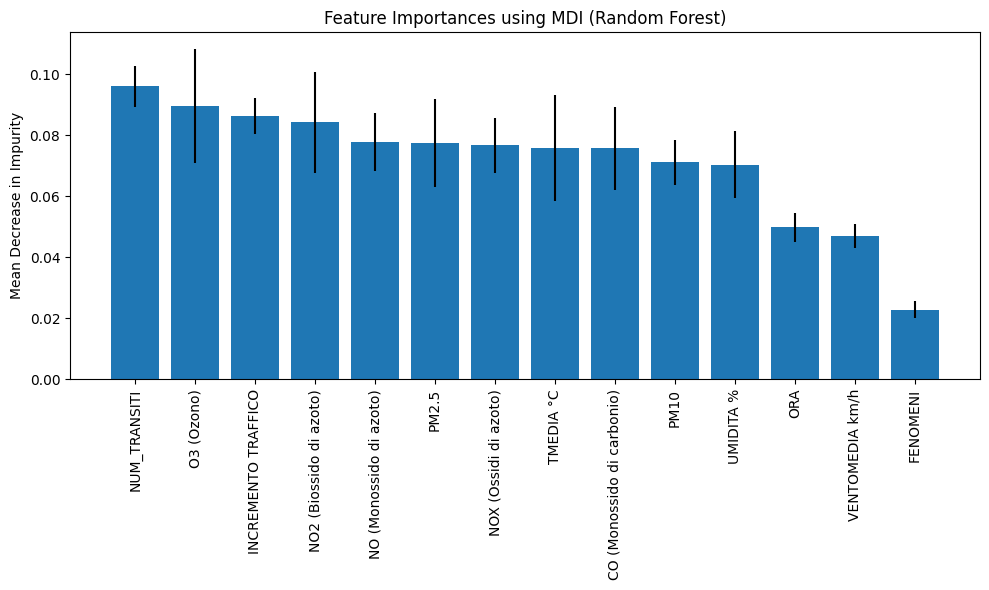

Confusion Matrix:
[[ 78  37   6   4   1   0   0   0]
 [ 82 125  32  19  15   7   8   3]
 [ 37  63  99  34  38  20  11  11]
 [ 18  49  37  43  23  25  16  11]
 [ 19  25  41  22  31  17  10   8]
 [  4  18  27  25  13  18  12  15]
 [  5   3   2  10  10  10  11  10]
 [  2   8   9   9  11  12   7  33]]

Predizioni corrette per classe:
[1%, 5%): 78
[5%, 10%): 125
[10%, 15%): 99
[15%, 20%): 43
[20%, 30%): 31
[30%, 40%): 18
[40%, 50%): 11
[50%, inf): 33

Predizioni errate per classe:
[1%, 5%): 48
[5%, 10%): 166
[10%, 15%): 214
[15%, 20%): 179
[20%, 30%): 142
[30%, 40%): 114
[40%, 50%): 50
[50%, inf): 58


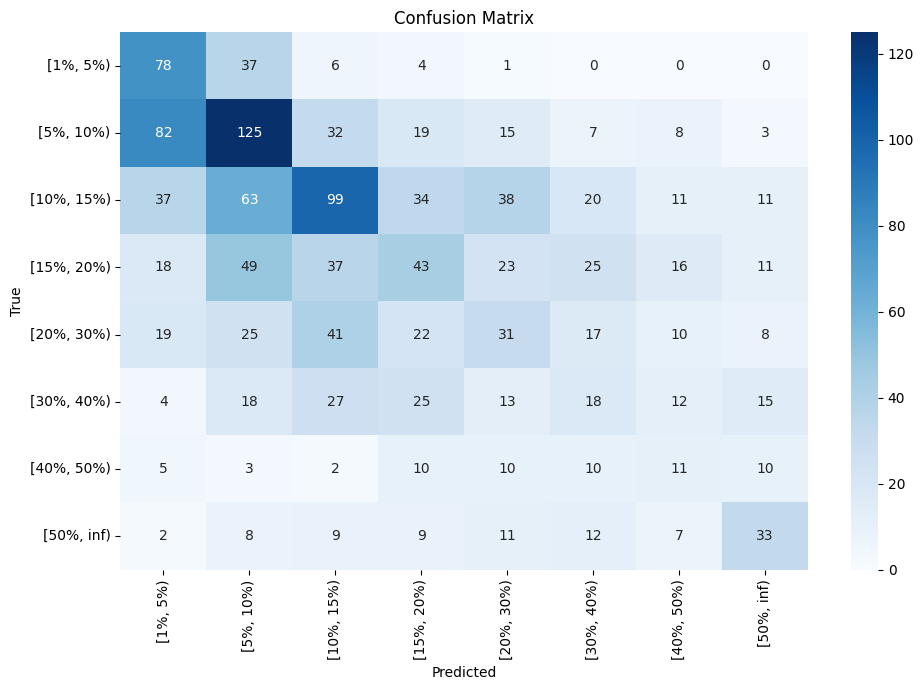

In [ ]:
# Rimozione delle righe con valori NaN
df_C6H6 = df_C6H6.dropna()

# Etichette ordinate
ordered_labels = labels_C6H6_8classi
#ordered_labels = labels_C6H6_5classi
#ordered_labels = labels_C6H6_3classi
#ordered_labels = labels_C6H6_2classi


# Separazione delle feature dal target
X = df_C6H6.drop(columns=['GIO_ID', 'C6H6 (Benzene)_class', 'C6H6 (Benzene)_inc', 'C6H6 (Benzene)'])
y = df_C6H6['C6H6 (Benzene)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inizializzazione di SMOTE
smote = SMOTE(random_state=42)

# Applicazione di SMOTE solo al training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Previsione dei target per il test set
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Calcolo della deviazione standard dell'importanza tra gli alberi nella random forest
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Features più importanti nella tabella
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici per importanza decrescente
indices = np.argsort(importances)[::-1]

# Ordiniamento nomi e valori
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)

print("Confusion Matrix:")
print(cm)

# Numero di predizioni corrette per ogni classe (diagonale)
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")


# Numero di errori per ogni classe (totale riga - diagonale)
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_CO, conteggi_CO = stampa_intervalli_incremento(df_finale, 'CO (Monossido di carbonio)', n_classi=5)
#print(conteggi)

In [ ]:
bins_CO_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_CO_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_CO_5classi = [1, 5, 10, 15, 25, np.inf]
labels_CO_5classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 25%)', '[25%, inf)']

bins_CO_3classi = [1, 10, 20, np.inf]
labels_CO_3classi = ['[1%, 10%)', '[10%, 20%)', '[20%, inf)']

bins_CO_2classi = [1, 15, np.inf]
labels_CO_2classi = ['[1%, 15%)', '[15%, inf)']

df_CO, conteggi_CO = calcola_incremento_con_bins_labels(df_finale, 'CO (Monossido di carbonio)', bins_CO_8classi, labels_CO_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_CO, conteggi_CO = calcola_incremento_con_bins_labels(df_finale, 'CO (Monossido di carbonio)', bins_CO_5classi, labels_CO_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_CO, conteggi_CO = calcola_incremento_con_bins_labels(df_finale, 'CO (Monossido di carbonio)', bins_CO_3classi, labels_CO_3classi, groupby_col='GIO_ID', conta_classi=True)
#df_CO, conteggi_CO = calcola_incremento_con_bins_labels(df_finale, 'CO (Monossido di carbonio)', bins_CO_2classi, labels_CO_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_CO)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
CO (Monossido di carbonio)_class
[1%, 5%)       268
[5%, 10%)     2973
[10%, 15%)    2418
[15%, 20%)    1798
[20%, 30%)    1204
[30%, 40%)     761
[40%, 50%)     338
[50%, inf)     190
Name: conteggio, dtype: int64


/tmp/ipython-input-39-4230021760.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[colonna_inc] = df.groupby(groupby_col)[colonna].pct_change() * 100


              precision    recall  f1-score   support

    [1%, 5%)       0.40      0.85      0.55        20
   [5%, 10%)       0.67      0.73      0.70       279
  [10%, 15%)       0.54      0.48      0.50       222
  [15%, 20%)       0.43      0.34      0.38       157
  [20%, 30%)       0.32      0.35      0.34       122
  [30%, 40%)       0.11      0.10      0.11        70
  [40%, 50%)       0.23      0.26      0.24        46
  [50%, inf)       0.27      0.25      0.26        16

    accuracy                           0.48       932
   macro avg       0.37      0.42      0.38       932
weighted avg       0.48      0.48      0.47       932

                    Feature  Importance
2            C6H6 (Benzene)    0.110677
1              NUM_TRANSITI    0.097370
8                     PM2.5    0.086018
9                 TMEDIA °C    0.085893
6                O3 (Ozono)    0.082409
4   NO2 (Biossido di azoto)    0.075415
13      INCREMENTO TRAFFICO    0.073166
7                      PM10  

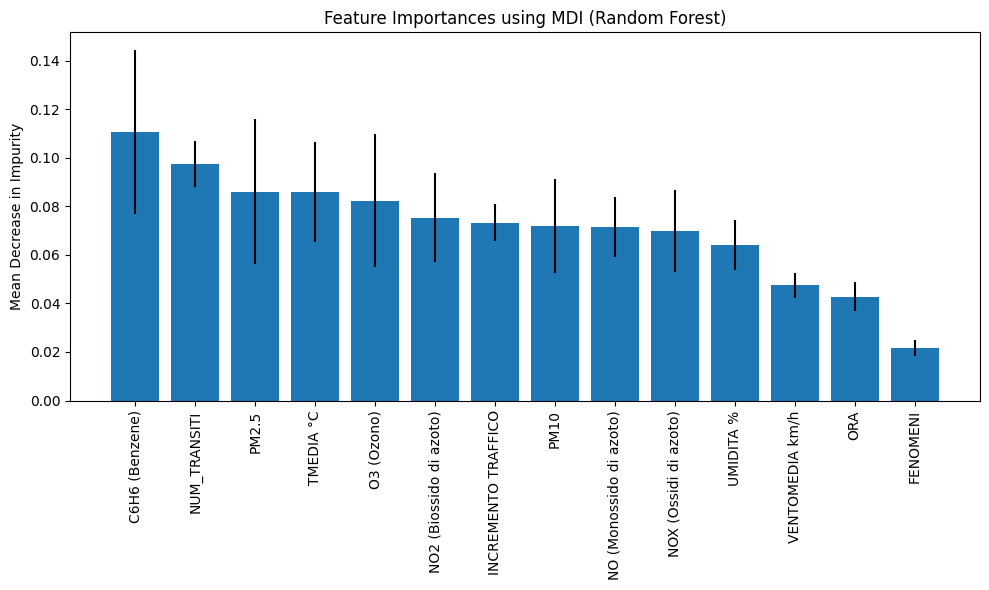

Confusion Matrix:
[[ 17   3   0   0   0   0   0   0]
 [ 15 203  37  17   4   2   1   0]
 [  7  60 106  15  19  10   4   1]
 [  2  16  29  54  35  12   6   3]
 [  1  12  15  24  43  14  11   2]
 [  0   5   9  10  17   7  18   4]
 [  0   2   2   4  10  15  12   1]
 [  0   1   0   2   6   3   0   4]]

Predizioni corrette per classe:
[1%, 5%): 17
[5%, 10%): 203
[10%, 15%): 106
[15%, 20%): 54
[20%, 30%): 43
[30%, 40%): 7
[40%, 50%): 12
[50%, inf): 4

Predizioni errate per classe:
[1%, 5%): 3
[5%, 10%): 76
[10%, 15%): 116
[15%, 20%): 103
[20%, 30%): 79
[30%, 40%): 63
[40%, 50%): 34
[50%, inf): 12


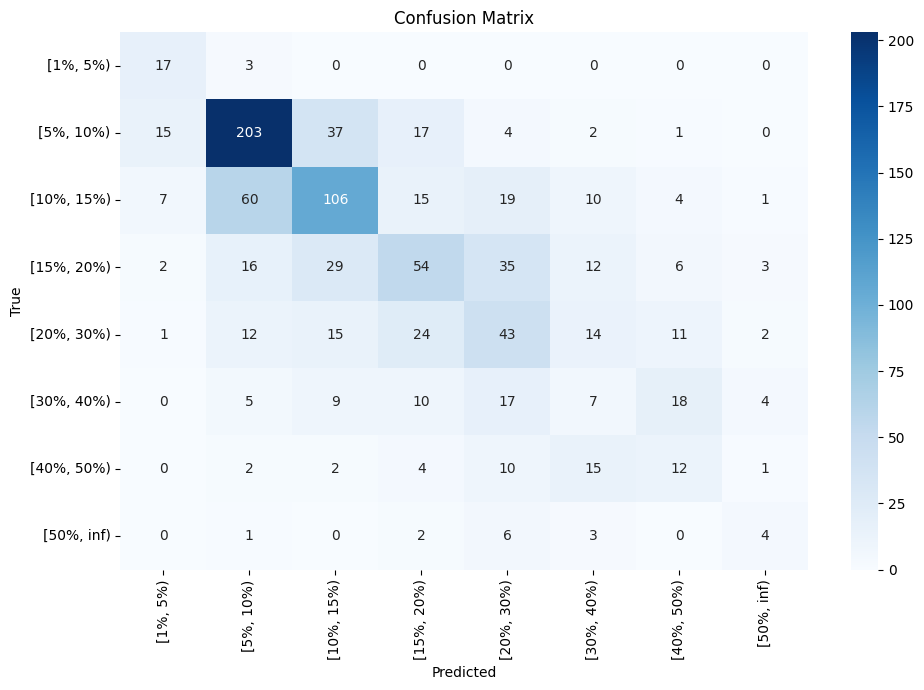

In [ ]:
# Rimozione delle righe con valori NaN
df_CO = df_CO.dropna()

# Etichette ordinate
ordered_labels = labels_CO_8classi
#ordered_labels = labels_CO_5classi
#ordered_labels = labels_CO_3classi
#ordered_labels = labels_CO_2classi

# Separazione delle feature dal target
X = df_CO.drop(columns=['GIO_ID', 'CO (Monossido di carbonio)', 'CO (Monossido di carbonio)_inc', 'CO (Monossido di carbonio)_class'])
y = df_CO['CO (Monossido di carbonio)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Inizializzazione di SMOTE
smote = SMOTE(random_state=42)

# Applicazione di SMOTE solo al training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione dei target per il test set
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Calcolo della deviazione standard dell'importanza tra gli alberi nella random forest
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Features più importanti nella tabella
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici per importanza decrescente
indices = np.argsort(importances)[::-1]

# Ordiniamento nomi e valori
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)

print("Confusion Matrix:")
print(cm)

# Numero di predizioni corrette per ogni classe (diagonale)
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Numero di errori per ogni classe (totale riga - diagonale)
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_NO, conteggi_NO = stampa_intervalli_incremento(df_finale, 'NO (Monossido di azoto)', n_classi=5)
#print(conteggi)

In [ ]:
bins_NO_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_NO_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_NO_5classi = [1, 10, 15, 30, 50, np.inf]
labels_NO_5classi = ['[1%, 10%)', '[10%, 15%)', '[15%, 30%)', '[30%, 50%)', '[50%, inf)']

bins_NO_3classi = [1, 15, 50, np.inf]
labels_NO_3classi = ['[1%, 15%)', '[15%, 50%)', '[50%, inf)']

bins_NO_2classi = [1, 25, np.inf]
labels_NO_2classi = ['[1%, 25%)', '[25%, inf)']

df_NO, conteggi_NO = calcola_incremento_con_bins_labels(df_finale, 'NO (Monossido di azoto)', bins_NO_8classi, labels_NO_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO, conteggi_NO = calcola_incremento_con_bins_labels(df_finale, 'NO (Monossido di azoto)', bins_NO_5classi, labels_NO_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO, conteggi_NO = calcola_incremento_con_bins_labels(df_finale, 'NO (Monossido di azoto)', bins_NO_3classi, labels_NO_3classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO, conteggi_NO = calcola_incremento_con_bins_labels(df_finale, 'NO (Monossido di azoto)', bins_NO_2classi, labels_NO_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_NO)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
NO (Monossido di azoto)_class
[1%, 5%)      1271
[5%, 10%)     2392
[10%, 15%)    2380
[15%, 20%)    1975
[20%, 30%)    2258
[30%, 40%)    1780
[40%, 50%)     725
[50%, inf)    3978
Name: conteggio, dtype: int64


/tmp/ipython-input-39-4230021760.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[colonna_inc] = df.groupby(groupby_col)[colonna].pct_change() * 100


              precision    recall  f1-score   support

    [1%, 5%)       0.23      0.43      0.30       130
   [5%, 10%)       0.25      0.27      0.26       253
  [10%, 15%)       0.22      0.19      0.20       262
  [15%, 20%)       0.16      0.14      0.15       223
  [20%, 30%)       0.13      0.10      0.11       242
  [30%, 40%)       0.15      0.14      0.15       201
  [40%, 50%)       0.06      0.09      0.07        67
  [50%, inf)       0.54      0.50      0.52       450

    accuracy                           0.27      1828
   macro avg       0.22      0.23      0.22      1828
weighted avg       0.27      0.27      0.27      1828

                       Feature  Importance
1                 NUM_TRANSITI    0.104223
13         INCREMENTO TRAFFICO    0.093826
5        NOX (Ossidi di azoto)    0.093497
2               C6H6 (Benzene)    0.080431
6                   O3 (Ozono)    0.079806
4      NO2 (Biossido di azoto)    0.079532
8                        PM2.5    0.070750
3   C

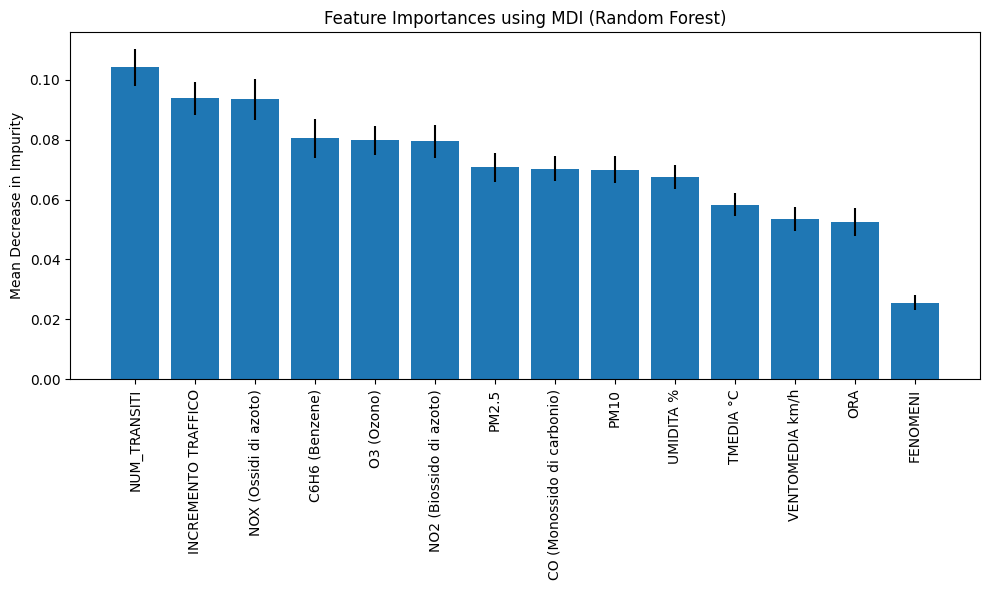

Confusion Matrix:
[[ 56  25  19  11   8   4   3   4]
 [ 51  68  30  30  23  23  10  18]
 [ 35  55  50  34  33  18  16  21]
 [ 28  31  21  31  27  23  17  45]
 [ 35  37  31  32  24  32  10  41]
 [ 13  20  30  13  32  29  12  52]
 [  7  11   8  12   3   9   6  11]
 [ 22  20  40  36  28  51  29 224]]

Predizioni corrette per classe:
[1%, 5%): 56
[5%, 10%): 68
[10%, 15%): 50
[15%, 20%): 31
[20%, 30%): 24
[30%, 40%): 29
[40%, 50%): 6
[50%, inf): 224

Predizioni errate per classe:
[1%, 5%): 74
[5%, 10%): 185
[10%, 15%): 212
[15%, 20%): 192
[20%, 30%): 218
[30%, 40%): 172
[40%, 50%): 61
[50%, inf): 226


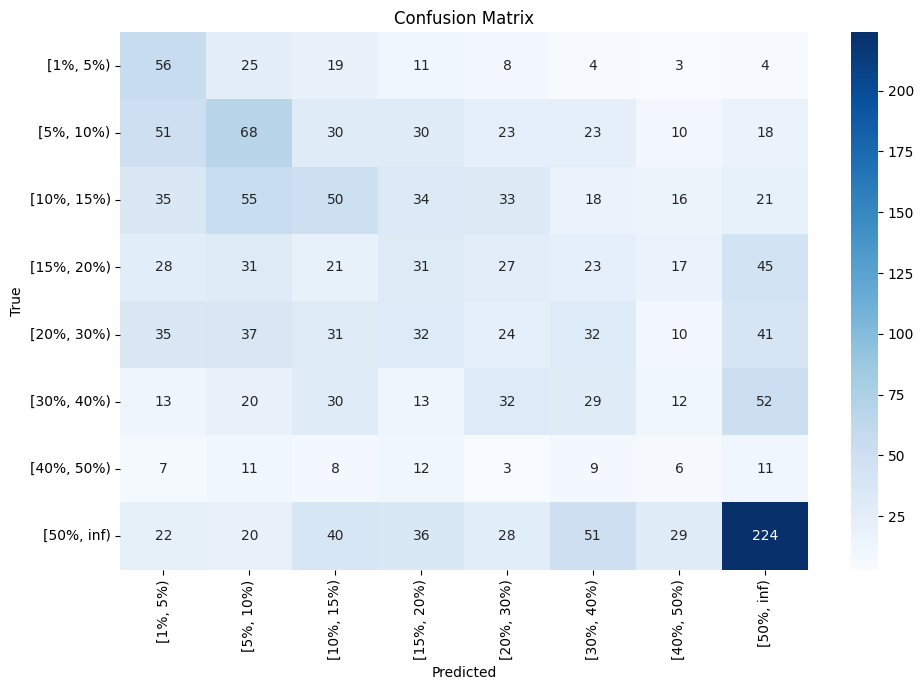

In [ ]:
# Rimozione delle righe con valori NaN
df_NO = df_NO.dropna()

# Etichette ordinate
ordered_labels = labels_NO_8classi
#ordered_labels = labels_NO_5classi
#ordered_labels = labels_NO_3classi
#ordered_labels = labels_NO_2classi

# Separazione delle feature dal target
X = df_NO.drop(columns=['GIO_ID', 'NO (Monossido di azoto)', 'NO (Monossido di azoto)_inc', 'NO (Monossido di azoto)_class'])
y = df_NO['NO (Monossido di azoto)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inizializzazione di SMOTE
smote = SMOTE(random_state=42)

# Applicazione di SMOTE solo al training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione dei target per il test set
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Calcolo della deviazione standard dell'importanza tra gli alberi nella random forest
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Features più importanti nella tabella
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici per importanza decrescente
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette (diagonale)
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_NO2, conteggi_NO2 = stampa_intervalli_incremento(df_finale, 'NO2 (Biossido di azoto)', n_classi=5)
#print(conteggi_NO2)

In [ ]:
bins_NO2_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_NO2_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_NO2_5classi = [1, 2, 4, 8, 14, np.inf]
labels_NO2_5classi = ['[1%, 2%)', '[2%, 4%)', '[4%, 8%)', '[8%, 14%)', '[14%, inf)']

bins_NO2_3classi = [1, 4, 10, np.inf]
labels_NO2_3classi = ['[1%, 4%)', '[4%, 10%)', '[10%, inf)']

bins_NO2_2classi = [1, 6, np.inf]
labels_NO2_2classi = ['[1%, 6%)', '[6%, inf)']

df_NO2, conteggi_NO2 = calcola_incremento_con_bins_labels(df_finale, 'NO2 (Biossido di azoto)', bins_NO2_8classi, labels_NO2_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO2, conteggi_NO2 = calcola_incremento_con_bins_labels(df_finale, 'NO2 (Biossido di azoto)', bins_NO2_5classi, labels_NO2_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO2, conteggi_NO2 = calcola_incremento_con_bins_labels(df_finale, 'NO2 (Biossido di azoto)', bins_NO2_3classi, labels_NO2_3classi, groupby_col='GIO_ID', conta_classi=True)
#df_NO2, conteggi_NO2 = calcola_incremento_con_bins_labels(df_finale, 'NO2 (Biossido di azoto)', bins_NO2_2classi, labels_NO2_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_NO2)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
NO2 (Biossido di azoto)_class
[1%, 5%)      6921
[5%, 10%)     5133
[10%, 15%)    2786
[15%, 20%)    1548
[20%, 30%)    1391
[30%, 40%)     495
[40%, 50%)     207
[50%, inf)     281
Name: conteggio, dtype: int64


              precision    recall  f1-score   support

    [1%, 5%)       0.53      0.55      0.54       736
   [5%, 10%)       0.31      0.26      0.29       549
  [10%, 15%)       0.20      0.19      0.19       279
  [15%, 20%)       0.11      0.12      0.12       149
  [20%, 30%)       0.13      0.15      0.14       143
  [30%, 40%)       0.07      0.09      0.08        58
  [40%, 50%)       0.04      0.04      0.04        26
  [50%, inf)       0.23      0.31      0.26        39

    accuracy                           0.33      1979
   macro avg       0.20      0.21      0.21      1979
weighted avg       0.34      0.33      0.33      1979

                       Feature  Importance
1                 NUM_TRANSITI    0.115874
6                   O3 (Ozono)    0.090574
13         INCREMENTO TRAFFICO    0.086987
2               C6H6 (Benzene)    0.085687
4      NO (Monossido di azoto)    0.076963
5        NOX (Ossidi di azoto)    0.075337
8                        PM2.5    0.074902
7    

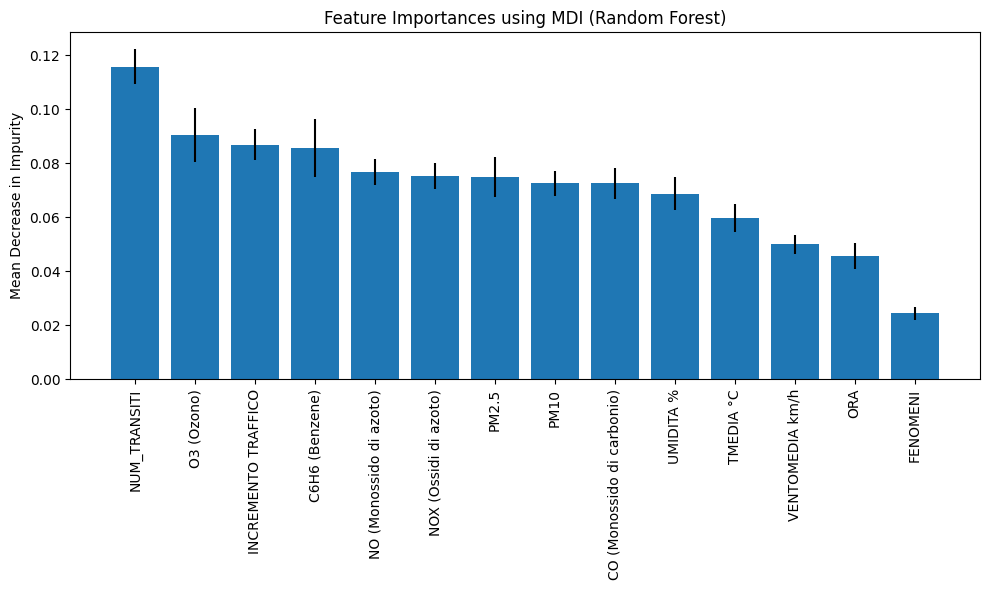

Confusion Matrix:
[[402 182  79  31  28   7   1   6]
 [202 145  83  50  41  17   6   5]
 [ 73  78  54  28  26   9   4   7]
 [ 47  27  20  18  22   8   3   4]
 [ 17  24  26  18  21  21   7   9]
 [ 11   8   7   5  13   5   4   5]
 [  3   3   3   3   5   3   1   5]
 [  1   1   3   6  11   3   2  12]]

Predizioni corrette per classe:
[1%, 5%): 402
[5%, 10%): 145
[10%, 15%): 54
[15%, 20%): 18
[20%, 30%): 21
[30%, 40%): 5
[40%, 50%): 1
[50%, inf): 12

Predizioni errate per classe:
[1%, 5%): 334
[5%, 10%): 404
[10%, 15%): 225
[15%, 20%): 131
[20%, 30%): 122
[30%, 40%): 53
[40%, 50%): 25
[50%, inf): 27


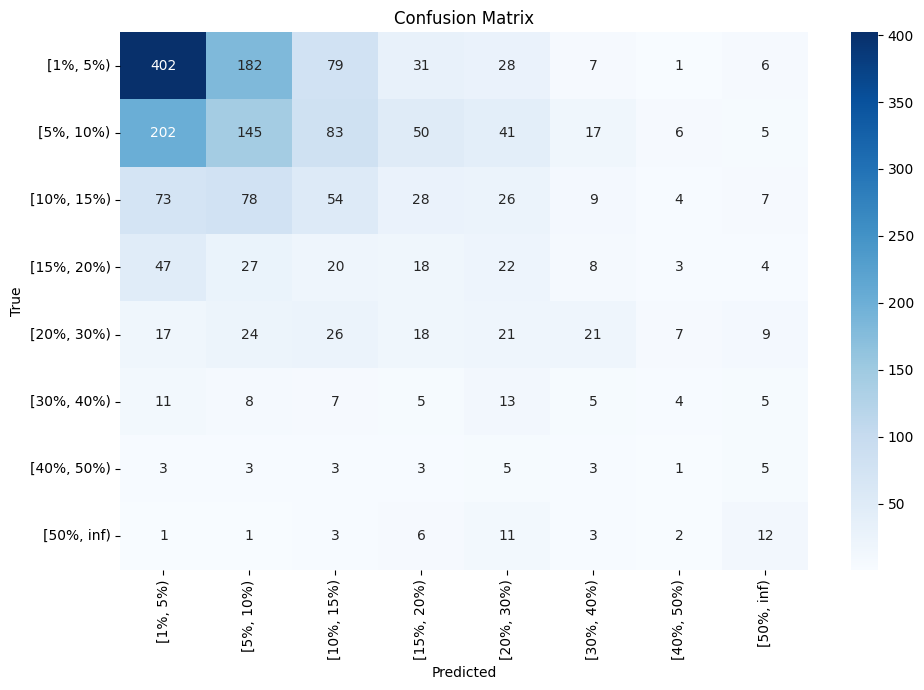

In [ ]:
# Rimozione delle righe con valori NaN
df_NO2 = df_NO2.dropna()

# Etichette ordinate
ordered_labels = labels_NO2_8classi
#ordered_labels = labels_NO2_5classi
#ordered_labels = labels_NO2_3classi
#ordered_labels = labels_NO2_2classi

# Separazione delle feature dal target
X = df_NO2.drop(columns=['GIO_ID','NO2 (Biossido di azoto)', 'NO2 (Biossido di azoto)_inc', 'NO2 (Biossido di azoto)_class'])
y = df_NO2['NO2 (Biossido di azoto)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inizializzazione di SMOTE
smote = SMOTE(random_state=42)

# Applicazione di SMOTE solo al training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione dei target per il test set
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Calcolo della deviazione standard dell'importanza tra gli alberi nella random forest
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Features più importanti nella tabella
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici per importanza decrescente
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette per classe
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_NOX, conteggi_NOX = stampa_intervalli_incremento(df_finale, 'NOX (Ossidi di azoto)', n_classi=2)
#print(conteggi_NOX)

In [1]:
bins_NOX_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_NOX_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_NOX_5classi = [1, 3, 8, 13, 24, np.inf]
labels_NOX_5classi = ['[1%, 3%)', '[3%, 8%)', '[8%, 13%)', '[13%, 24%)', '[24%, inf)']

bins_NOX_3classi = [1, 6, 16, np.inf]
labels_NOX_3classi = ['[1%, 6%)', '[6%, 16%)', '[10%, inf)']

bins_NOX_2classi = [1, 10, np.inf]
labels_NOX_2classi = ['[1%, 10%)', '[10%, inf)']

#df_NOX, conteggi_NOX = calcola_incremento_con_bins_labels(df_finale, 'NOX (Ossidi di azoto)', bins_NOX_8classi, labels_NOX_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_NOX, conteggi_NOX = calcola_incremento_con_bins_labels(df_finale, 'NOX (Ossidi di azoto)', bins_NOX_5classi, labels_NOX_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_NOX, conteggi_NOX = calcola_incremento_con_bins_labels(df_finale, 'NOX (Ossidi di azoto)', bins_NOX_3classi, labels_NOX_3classi, groupby_col='GIO_ID', conta_classi=True)
df_NOX, conteggi_NOX = calcola_incremento_con_bins_labels(df_finale, 'NOX (Ossidi di azoto)', bins_NOX_2classi, labels_NOX_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_NOX)

NameError: name 'np' is not defined

              precision    recall  f1-score   support

    [1%, 5%)       0.34      0.46      0.40       502
   [5%, 10%)       0.23      0.36      0.28       438
  [10%, 15%)       0.20      0.13      0.16       349
  [15%, 20%)       0.15      0.06      0.08       223
  [20%, 30%)       0.09      0.04      0.06       244
  [30%, 40%)       0.08      0.02      0.04       135
  [40%, 50%)       0.05      0.14      0.07        66
  [50%, inf)       0.39      0.24      0.30       143

    accuracy                           0.24      2100
   macro avg       0.19      0.18      0.17      2100
weighted avg       0.22      0.24      0.22      2100

                       Feature  Importance
1                 NUM_TRANSITI    0.104441
13         INCREMENTO TRAFFICO    0.101856
5      NO2 (Biossido di azoto)    0.086962
6                   O3 (Ozono)    0.086871
4      NO (Monossido di azoto)    0.083831
7                         PM10    0.071751
2               C6H6 (Benzene)    0.071383
11   

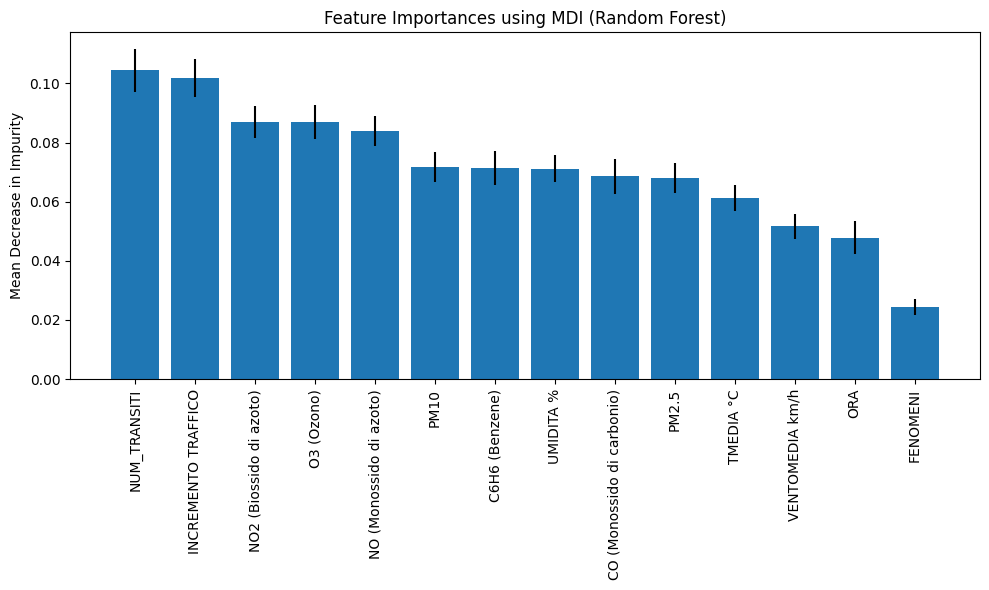

Confusion Matrix:
[[233 173  43  10  22   3  15   3]
 [165 156  43  23  23   3  21   4]
 [112 123  47  15  21   4  22   5]
 [ 64  77  28  13  11   6  17   7]
 [ 50  78  42  11  10   8  38   7]
 [ 19  38  15   8   8   3  27  17]
 [ 15  13   4   5   6   2   9  12]
 [ 19  24  11   1  12   7  34  35]]

Predizioni corrette per classe:
[1%, 5%): 233
[5%, 10%): 156
[10%, 15%): 47
[15%, 20%): 13
[20%, 30%): 10
[30%, 40%): 3
[40%, 50%): 9
[50%, inf): 35

Predizioni errate per classe:
[1%, 5%): 269
[5%, 10%): 282
[10%, 15%): 302
[15%, 20%): 210
[20%, 30%): 234
[30%, 40%): 132
[40%, 50%): 57
[50%, inf): 108


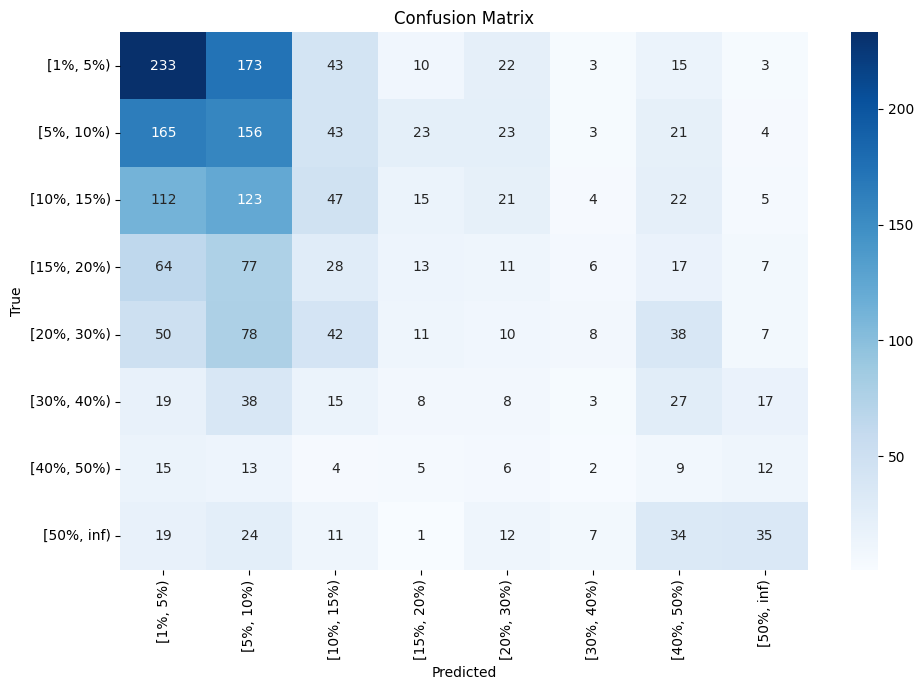

In [ ]:
# Rimozione delle righe con valori NaN
df_NOX = df_NOX.dropna()

# Etichette ordinate
ordered_labels = labels_NOX_8classi
#ordered_labels = labels_NOX_5classi
#ordered_labels = labels_NOX_3classi
#ordered_labels = labels_NOX_2classi

# Separazione delle feature dal target
X = df_NOX.drop(columns=['GIO_ID','NOX (Ossidi di azoto)', 'NOX (Ossidi di azoto)_inc', 'NOX (Ossidi di azoto)_class'])
y = df_NOX['NOX (Ossidi di azoto)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applicazione di SMOTE solo sui dati di training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1500,
    max_depth=40,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Deviazione standard dell'importanza tra gli alberi
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Tabella delle feature più importanti
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico dell'importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette per classe
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_O3, conteggi_O3 = stampa_intervalli_incremento(df_finale, 'O3 (Ozono)', n_classi=3)
#print(conteggi_O3)

In [ ]:
bins_O3_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_O3_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_O3_5classi = [1, 2, 5, 10, 22, np.inf]
labels_O3_5classi = ['[1%, 2%)', '[2%, 5%)', '[5%, 10%)', '[10%, 20%)', '[20%, inf)']

bins_O3_3classi = [1, 4, 12, np.inf]
labels_O3_3classi = ['[1%, 4%)', '[4%, 12%)', '[12%, inf)']

bins_O3_2classi = [1, 10, np.inf]
labels_O3_2classi = ['[1%, 10%)', '[10%, inf)']

df_O3, conteggi_O3 = calcola_incremento_con_bins_labels(df_finale, 'O3 (Ozono)', bins_O3_8classi, labels_O3_8classi, groupby_col='GIO_ID', conta_classi=True)
#df_O3, conteggi_O3 = calcola_incremento_con_bins_labels(df_finale, 'O3 (Ozono)', bins_O3_5classi, labels_O3_5classi, groupby_col='GIO_ID', conta_classi=True)
#df_O3, conteggi_O3 = calcola_incremento_con_bins_labels(df_finale, 'O3 (Ozono)', bins_O3_3classi, labels_O3_3classi, groupby_col='GIO_ID', conta_classi=True)
#df_O3, conteggi_O3 = calcola_incremento_con_bins_labels(df_finale, 'O3 (Ozono)', bins_O3_2classi, labels_O3_2classi, groupby_col='GIO_ID', conta_classi=True)

print(conteggi_O3)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
O3 (Ozono)_class
[1%, 5%)      5689
[5%, 10%)     4026
[10%, 15%)    2569
[15%, 20%)    1618
[20%, 30%)    1615
[30%, 40%)     864
[40%, 50%)     344
[50%, inf)    1083
Name: conteggio, dtype: int64


              precision    recall  f1-score   support

    [1%, 5%)       0.55      0.73      0.62       599
   [5%, 10%)       0.30      0.29      0.30       384
  [10%, 15%)       0.21      0.13      0.16       236
  [15%, 20%)       0.14      0.05      0.07       149
  [20%, 30%)       0.15      0.06      0.09       164
  [30%, 40%)       0.15      0.03      0.05        64
  [40%, 50%)       0.04      0.32      0.08        28
  [50%, inf)       0.28      0.21      0.24       107

    accuracy                           0.36      1731
   macro avg       0.23      0.23      0.20      1731
weighted avg       0.33      0.36      0.34      1731

                       Feature  Importance
1                 NUM_TRANSITI    0.105912
2               C6H6 (Benzene)    0.103287
5      NO2 (Biossido di azoto)    0.097690
4      NO (Monossido di azoto)    0.097139
11         INCREMENTO TRAFFICO    0.096249
6        NOX (Ossidi di azoto)    0.089535
9                    UMIDITA %    0.087108
0    

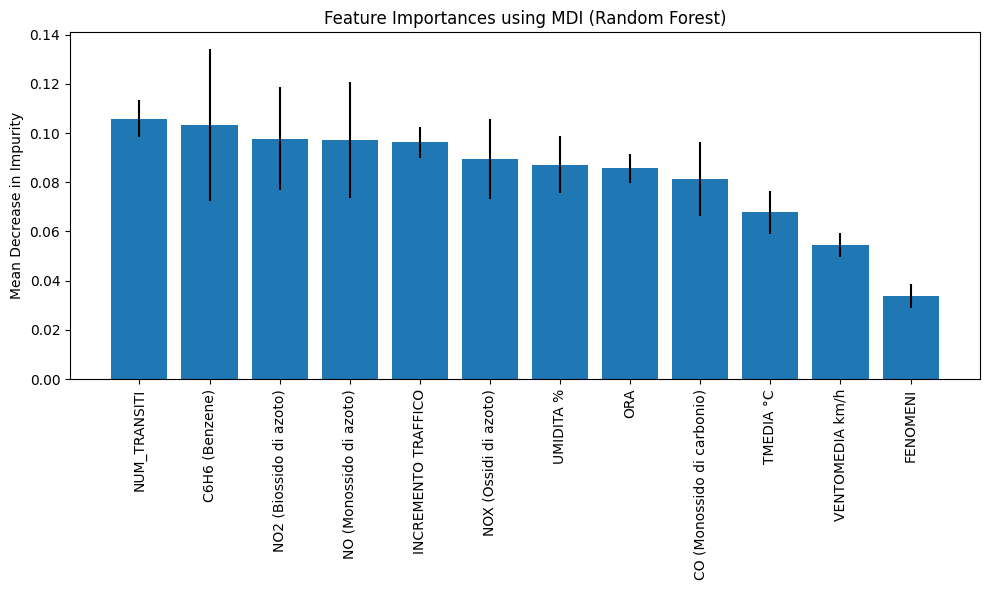

Confusion Matrix:
[[435 101  17   7  10   1  23   5]
 [181 112  39  12   5   0  28   7]
 [ 74  63  31  14  13   3  29   9]
 [ 37  38  24   7   8   1  25   9]
 [ 46  31  22   4  10   3  37  11]
 [ 11  13   4   2   6   2  16  10]
 [  4   3   3   2   1   1   9   5]
 [  9   7   8   3  14   2  42  22]]

Predizioni corrette per classe:
[1%, 5%): 435
[5%, 10%): 112
[10%, 15%): 31
[15%, 20%): 7
[20%, 30%): 10
[30%, 40%): 2
[40%, 50%): 9
[50%, inf): 22

Predizioni errate per classe:
[1%, 5%): 164
[5%, 10%): 272
[10%, 15%): 205
[15%, 20%): 142
[20%, 30%): 154
[30%, 40%): 62
[40%, 50%): 19
[50%, inf): 85


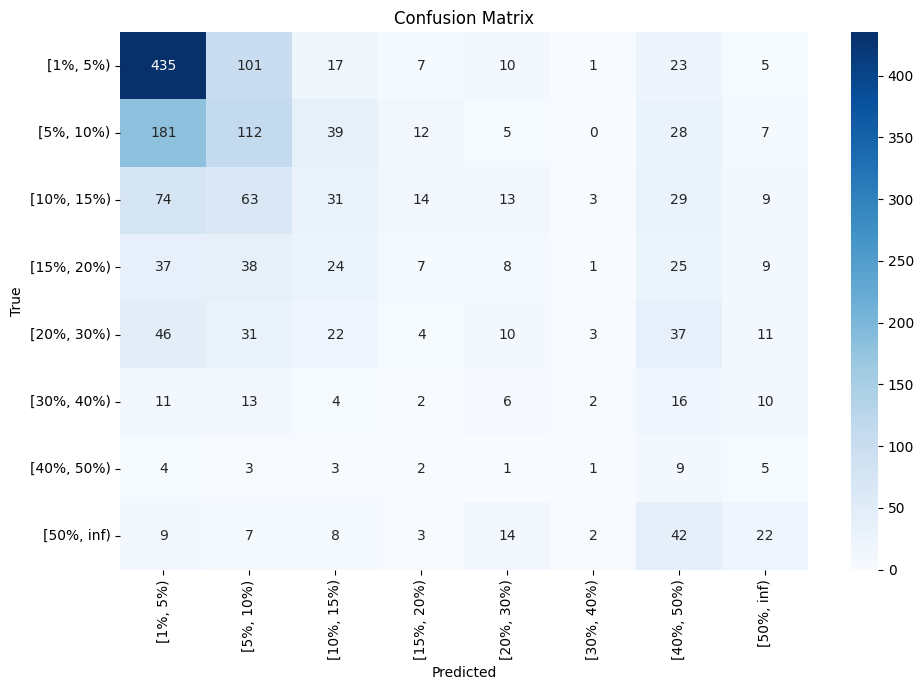

In [ ]:
# Rimozione delle righe con valori NaN
df_O3 = df_O3.dropna()

# Etichette ordinate
ordered_labels = labels_O3_8classi
#ordered_labels = labels_O3_5classi
#ordered_labels = labels_O3_3classi
#ordered_labels = labels_O3_2classi

# Separazione delle feature dal target
X = df_O3.drop(columns=[
    'GIO_ID', 'PM10', 'PM2.5',
    'O3 (Ozono)', 'O3 (Ozono)_inc', 'O3 (Ozono)_class'
])
y = df_O3['O3 (Ozono)_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applicazione di SMOTE solo sui dati di training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Deviazione standard dell'importanza tra gli alberi
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Tabella delle feature più importanti
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico dell'importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette per classe
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Raggruppamento giornaliero
df_daily = df_finale.groupby('GIO_ID').agg({
    'NUM_TRANSITI': 'sum',
    'C6H6 (Benzene)': 'mean',
    'CO (Monossido di carbonio)': 'mean',
    'NO (Monossido di azoto)': 'mean',
    'NO2 (Biossido di azoto)': 'mean',
    'NOX (Ossidi di azoto)': 'mean',
    'O3 (Ozono)': 'mean',
    'TMEDIA °C': 'mean',
    'FENOMENI': 'first',
    'UMIDITA %': 'first',
    'VENTOMEDIA km/h': 'first',
    'INCREMENTO TRAFFICO':'mean',
    'PM10': 'first',
    'PM2.5': 'first'
}).reset_index()


In [ ]:
def stampa_intervalli_incremento_pm(df, colonna, n_classi=2):
    # Calcolo incremento percentuale
    incremento = df[colonna].pct_change() * 100

    incremento = incremento.fillna(0)

    # Si mantengono solo gli incrementi positivi
    incremento[incremento <= 0] = np.nan

    # Calcolo soglie sui quantili (solo sui valori positivi)
    incrementi_positivi = incremento.dropna()
    quantili = incrementi_positivi.quantile([i / n_classi for i in range(1, n_classi)]).values

    # Creazione dei bins
    bins = [0] + quantili.tolist() + [np.inf]

    # Generazione etichette
    labels = []
    for i in range(len(bins) - 1):
        left = bins[i]
        right = bins[i + 1]
        left_label = f"{int(left)}%" if left != 0 else "1%"
        if right == np.inf:
            label = f"[{left_label}, inf)"
        else:
            right_label = f"{int(right)}%"
            label = f"[{left_label}, {right_label})"
        labels.append(label)

    # Classificazione
    classi = pd.cut(incrementi_positivi, bins=bins, labels=labels, right=False)

    # Conteggio delle istanze per classe
    conteggi = classi.value_counts(sort=False).rename("conteggio")

    # Stampa intervalli e conteggi
    print("Intervalli di incremento e relative occorrenze:")
    print(conteggi)

    return labels, conteggi


In [ ]:
labels_PM10, conteggi_PM10 = stampa_intervalli_incremento_pm(df_daily, 'PM10', n_classi=2)
#print(conteggi_PM10)

In [ ]:
bins_PM10_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_PM10_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_PM10_3classi = [1, 16, 40, np.inf]
labels_PM10_3classi = ['[1%, 16%)', '[16%, 40%)', '[40%, inf)']

bins_PM10_2classi = [1, 25, np.inf]
labels_PM10_2classi = ['[1%, 25%)', '[25%, inf)']

df_PM10, conteggi_PM10 = calcola_incremento_con_bins_labels(df_daily, 'PM10', bins_PM10_8classi, labels_PM10_8classi, groupby_col=None, conta_classi=True)
#df_PM10, conteggi_PM10 = calcola_incremento_con_bins_labels(df_daily, 'PM10', bins_PM10_3classi, labels_PM10_3classi, groupby_col=None, conta_classi=True)
#df_PM10, conteggi_PM10 = calcola_incremento_con_bins_labels(df_daily, 'PM10', bins_PM10_2classi, labels_PM10_2classi, groupby_col=None, conta_classi=True)

print(conteggi_PM10)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
PM10_class
[1%, 5%)       88
[5%, 10%)     101
[10%, 15%)     97
[15%, 20%)     86
[20%, 30%)    141
[30%, 40%)    102
[40%, 50%)     69
[50%, inf)    249
Name: conteggio, dtype: int64


              precision    recall  f1-score   support

    [1%, 5%)       0.17      0.20      0.19        20
   [5%, 10%)       0.23      0.17      0.19        18
  [10%, 15%)       0.08      0.09      0.09        22
  [15%, 20%)       0.14      0.20      0.17        15
  [20%, 30%)       0.18      0.12      0.14        26
  [30%, 40%)       0.07      0.04      0.05        23
  [40%, 50%)       0.06      0.14      0.08         7
  [50%, inf)       0.32      0.33      0.32        52

    accuracy                           0.19       183
   macro avg       0.16      0.16      0.15       183
weighted avg       0.19      0.19      0.19       183

                       Feature  Importance
0                 NUM_TRANSITI    0.104051
11         INCREMENTO TRAFFICO    0.091652
12                       PM2.5    0.085100
6                   O3 (Ozono)    0.083060
3      NO (Monossido di azoto)    0.081337
2   CO (Monossido di carbonio)    0.081112
1               C6H6 (Benzene)    0.080876
7    

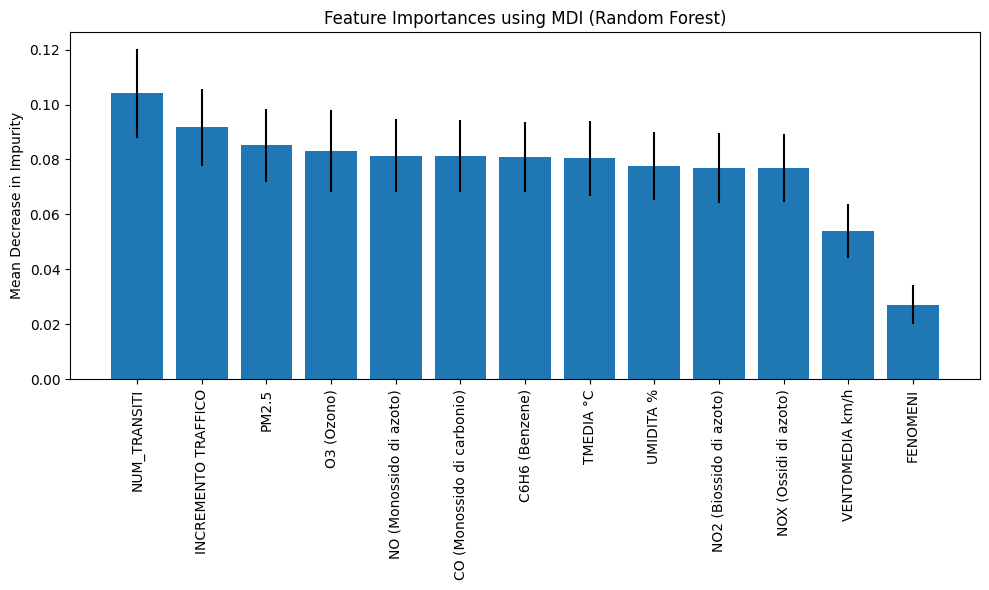

Confusion Matrix:
[[ 4  0  3  3  1  1  3  5]
 [ 1  3  4  1  4  2  0  3]
 [ 3  3  2  2  0  3  1  8]
 [ 2  2  1  3  2  0  0  5]
 [ 3  3  3  5  3  1  2  6]
 [ 1  0  4  3  2  1  4  8]
 [ 1  0  2  0  1  1  1  1]
 [ 8  2  5  4  4  6  6 17]]

Predizioni corrette per classe:
[1%, 5%): 4
[5%, 10%): 3
[10%, 15%): 2
[15%, 20%): 3
[20%, 30%): 3
[30%, 40%): 1
[40%, 50%): 1
[50%, inf): 17

Predizioni errate per classe:
[1%, 5%): 16
[5%, 10%): 15
[10%, 15%): 20
[15%, 20%): 12
[20%, 30%): 23
[30%, 40%): 22
[40%, 50%): 6
[50%, inf): 35


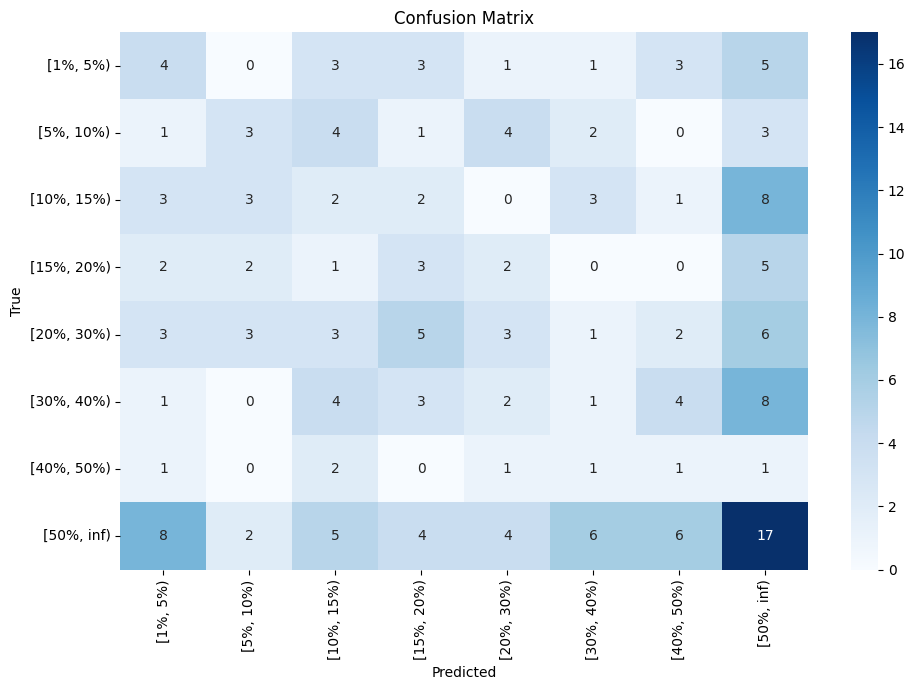

In [ ]:
# Rimozione delle righe con valori NaN
df_PM10 = df_PM10.dropna()

# Etichette ordinate
ordered_labels = labels_PM10_8classi
#ordered_labels = labels_PM10_3classi
#ordered_labels = labels_PM10_2classi

# Separazione delle feature dal target
X = df_PM10.drop(columns=['GIO_ID', 'PM10', 'PM10_inc', 'PM10_class'])
y = df_PM10['PM10_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applicazione di SMOTE solo sui dati di training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest con gestione dello sbilanciamento
model = RandomForestClassifier(
    n_estimators=800,
    max_depth=20,
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Deviazione standard dell'importanza tra gli alberi
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Tabella delle feature più importanti
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento degli indici
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico dell'importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette per classe
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
labels_PM25, conteggi_PM25 = stampa_intervalli_incremento_pm(df_daily, 'PM2.5', n_classi=2)

Intervalli di incremento e relative occorrenze:
PM2.5
[1%, 33%)     448
[33%, inf)    449
Name: conteggio, dtype: int64


/tmp/ipython-input-56-985891614.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  incremento = df[colonna].pct_change() * 100


In [ ]:
bins_PM25_8classi = [1, 5, 10, 15, 20, 30, 40, 50, np.inf]
labels_PM25_8classi = ['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']

bins_PM25_3classi = [1, 16, 40, np.inf]
labels_PM25_3classi = ['[1%, 16%)', '[16%, 40%)', '[40%, inf)']

bins_PM25_2classi = [1, 25, np.inf]
labels_PM25_2classi = ['[1%, 25%)', '[25%, inf)']

df_PM25, conteggi_PM25 = calcola_incremento_con_bins_labels(df_daily, 'PM2.5', bins_PM25_8classi, labels_PM25_8classi, groupby_col=None, conta_classi=True)
#df_PM25, conteggi_PM25 = calcola_incremento_con_bins_labels(df_daily, 'PM2.5', bins_PM25_3classi, labels_PM25_3classi, groupby_col=None, conta_classi=True)
#df_PM25, conteggi_PM25 = calcola_incremento_con_bins_labels(df_daily, 'PM2.5', bins_PM25_2classi, labels_PM25_2classi, groupby_col=None, conta_classi=True)

print(conteggi_PM25)

['[1%, 5%)', '[5%, 10%)', '[10%, 15%)', '[15%, 20%)', '[20%, 30%)', '[30%, 40%)', '[40%, 50%)', '[50%, inf)']
PM2.5_class
[1%, 5%)       45
[5%, 10%)      80
[10%, 15%)     81
[15%, 20%)     88
[20%, 30%)    124
[30%, 40%)    104
[40%, 50%)     67
[50%, inf)    307
Name: conteggio, dtype: int64


/tmp/ipython-input-39-4230021760.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[colonna_inc] = df[colonna].pct_change() * 100


              precision    recall  f1-score   support

   [0%, 10%)       0.67      1.00      0.80        49
  [10%, 20%)       0.00      0.00      0.00         5
  [20%, 30%)       0.00      0.00      0.00         4
  [30%, 40%)       0.00      0.00      0.00         4
  [40%, 50%)       0.00      0.00      0.00         1
  [50%, 60%)       0.00      0.00      0.00         6
  [60%, 70%)       0.00      0.00      0.00         2
  [70%, 80%)       0.00      0.00      0.00         1
  [80%, 90%)       0.00      0.00      0.00         1

    accuracy                           0.67        73
   macro avg       0.07      0.11      0.09        73
weighted avg       0.45      0.67      0.54        73

                      Feature  Importance
0                NUM_TRANSITI    0.138504
5       NOX (Ossidi di azoto)    0.122147
4     NO2 (Biossido di azoto)    0.111765
6                  O3 (Ozono)    0.111752
9                        PM10    0.109425
3     NO (Monossido di azoto)    0.101884
1

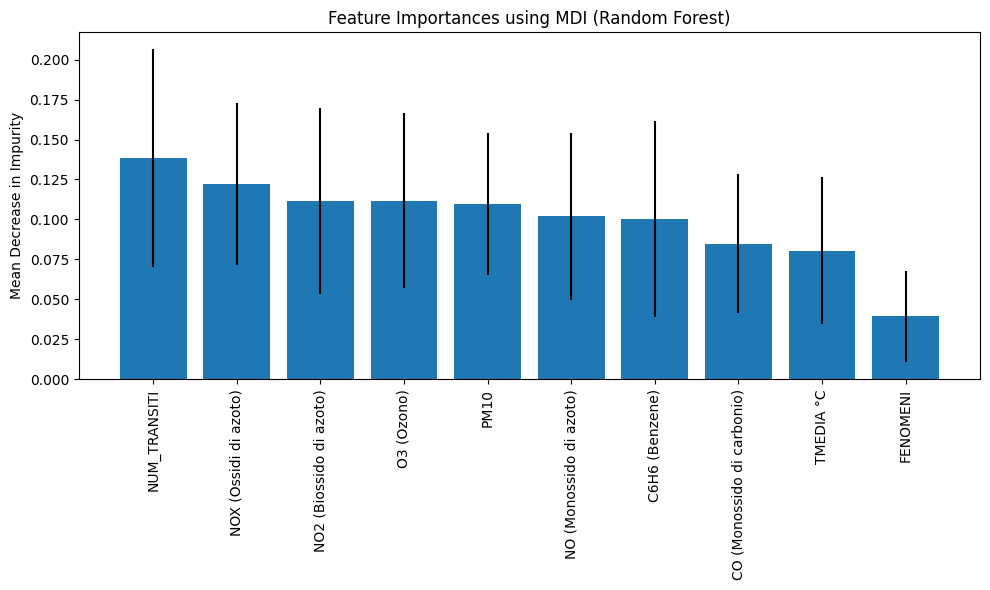

In [ ]:
# Rimozione delle righe con valori NaN
df_PM25 = df_PM25.dropna()

# Etichette ordinate
ordered_labels = labels_PM25_8classi
#ordered_labels = labels_PM25_3classi
#ordered_labels = labels_PM25_2classi

# Separazione delle feature dal target
X = df_PM25.drop(columns=['GIO_ID', 'PM2.5', 'PM2.5_inc', 'PM2.5_class'])
y = df_PM25['PM2.5_class']

# Suddivisione dei dati in training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applicazione di SMOTE solo sui dati di training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creazione del modello Random Forest con gestione dello sbilanciamento
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

# Training del modello sui dati bilanciati
model.fit(X_train_resampled, y_train_resampled)

# Training del modello
#model.fit(X_train, y_train)

# Previsione dei target per il test set
y_pred = model.predict(X_test)

# Valutazione del modello
report = classification_report(y_test, y_pred, labels=ordered_labels, zero_division=0)
print(report)

# Importanza delle features
importances = model.feature_importances_
features = X.columns

# Deviazione standard tra gli alberi
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Tabella delle feature più importanti
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Ordinamento per grafico
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Grafico dell'importanza delle feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align="center")
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_title("Feature Importances using MDI (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
print("Confusion Matrix:")
print(cm)

# Predizioni corrette per classe
correct_preds = np.diag(cm)
print("\nPredizioni corrette per classe:")
for label, correct in zip(ordered_labels, correct_preds):
    print(f"{label}: {correct}")

# Predizioni errate per classe
errors = cm.sum(axis=1) - correct_preds
print("\nPredizioni errate per classe:")
for label, err in zip(ordered_labels, errors):
    print(f"{label}: {err}")

# Grafico della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()